# Setting up a PEST interface from MODFLOW6 using the `PstFrom` class

The `PstFrom` class is a generalization of the prototype `PstFromFlopy` class. The generalization in `PstFrom` means users need to explicitly define what files are to be parameterized and what files contain model outputs to treat as observations.  Two primary types of files are supported:  arrays and lists.  Array files contain a data type (usually floating points) while list files will have a few columns that contain index information and then columns of floating point values.  

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyemu
import flopy

An existing MODFLOW6 model is in the directory `freyberg_mf6`.  Lets check it out:

In [2]:
org_model_ws = os.path.join('freyberg_mf6')
os.listdir(org_model_ws)

['freyberg6.dis',
 'freyberg6.dis.grb',
 'freyberg6.dis_botm_layer1.txt',
 'freyberg6.dis_botm_layer2.txt',
 'freyberg6.dis_botm_layer3.txt',
 'freyberg6.dis_delc.txt',
 'freyberg6.dis_delr.txt',
 'freyberg6.dis_idomain_layer1.txt',
 'freyberg6.dis_idomain_layer2.txt',
 'freyberg6.dis_idomain_layer3.txt',
 'freyberg6.dis_top.txt',
 'freyberg6.ghb',
 'freyberg6.ghb_stress_period_data_1.txt',
 'freyberg6.ic',
 'freyberg6.ic_strt_layer1.txt',
 'freyberg6.ic_strt_layer2.txt',
 'freyberg6.ic_strt_layer3.txt',
 'freyberg6.ims',
 'freyberg6.lst',
 'freyberg6.nam',
 'freyberg6.npf',
 'freyberg6.npf_icelltype_layer1.txt',
 'freyberg6.npf_icelltype_layer2.txt',
 'freyberg6.npf_icelltype_layer3.txt',
 'freyberg6.npf_k33_layer1.txt',
 'freyberg6.npf_k33_layer2.txt',
 'freyberg6.npf_k33_layer3.txt',
 'freyberg6.npf_k_layer1.txt',
 'freyberg6.npf_k_layer2.txt',
 'freyberg6.npf_k_layer3.txt',
 'freyberg6.oc',
 'freyberg6.rch',
 'freyberg6.rch_recharge_1.txt',
 'freyberg6.rch_recharge_10.txt',
 'freyb

You can see that all the input array and list data for this model have been written "externally" - this is key to using the `PstFrom` class. 

Let's quickly viz the model top just to remind us of what we are dealing with:

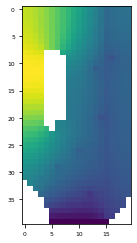

In [3]:
id_arr = np.loadtxt(os.path.join(org_model_ws,"freyberg6.dis_idomain_layer3.txt"))
top_arr = np.loadtxt(os.path.join(org_model_ws,"freyberg6.dis_top.txt"))
top_arr[id_arr==0] = np.nan
plt.imshow(top_arr)

Now let's copy those files to a temporary location just to make sure we don't goof up those original files:

In [4]:
tmp_model_ws = "temp_pst_from"
if os.path.exists(tmp_model_ws):
    shutil.rmtree(tmp_model_ws)
shutil.copytree(org_model_ws,tmp_model_ws)
os.listdir(tmp_model_ws)

['freyberg6.dis',
 'freyberg6.dis.grb',
 'freyberg6.dis_botm_layer1.txt',
 'freyberg6.dis_botm_layer2.txt',
 'freyberg6.dis_botm_layer3.txt',
 'freyberg6.dis_delc.txt',
 'freyberg6.dis_delr.txt',
 'freyberg6.dis_idomain_layer1.txt',
 'freyberg6.dis_idomain_layer2.txt',
 'freyberg6.dis_idomain_layer3.txt',
 'freyberg6.dis_top.txt',
 'freyberg6.ghb',
 'freyberg6.ghb_stress_period_data_1.txt',
 'freyberg6.ic',
 'freyberg6.ic_strt_layer1.txt',
 'freyberg6.ic_strt_layer2.txt',
 'freyberg6.ic_strt_layer3.txt',
 'freyberg6.ims',
 'freyberg6.lst',
 'freyberg6.nam',
 'freyberg6.npf',
 'freyberg6.npf_icelltype_layer1.txt',
 'freyberg6.npf_icelltype_layer2.txt',
 'freyberg6.npf_icelltype_layer3.txt',
 'freyberg6.npf_k33_layer1.txt',
 'freyberg6.npf_k33_layer2.txt',
 'freyberg6.npf_k33_layer3.txt',
 'freyberg6.npf_k_layer1.txt',
 'freyberg6.npf_k_layer2.txt',
 'freyberg6.npf_k_layer3.txt',
 'freyberg6.oc',
 'freyberg6.rch',
 'freyberg6.rch_recharge_1.txt',
 'freyberg6.rch_recharge_10.txt',
 'freyb

Now we need just a tiny bit of info about the spatial discretization of the model - this is needed to work out separation distances between parameters for build a geostatistical prior covariance matrix later.

Here we will load the flopy sim and model instance just to help us define some quantities later - flopy is not required to use the `PstFrom` class.

In [5]:
sim = flopy.mf6.MFSimulation.load(sim_ws=tmp_model_ws)
m = sim.get_model("freyberg6")


loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package oc...
    loading package wel...
    loading package rch...
    loading package ghb...
    loading package sfr...
    loading package obs...
  loading ims package freyberg6...


Here we use the simple `SpatialReference` pyemu implements to help us spatially locate parameters

In [6]:
sr = pyemu.helpers.SpatialReference.from_namfile(
        os.path.join(tmp_model_ws, "freyberg6.nam"),
        delr=m.dis.delr.array, delc=m.dis.delc.array)
sr

   could not remove start_datetime


xul:0; yul:10000; rotation:0; proj4_str:None; units:meters; lenuni:2; length_multiplier:1.0

Now we can instantiate a `PstFrom` class instance

In [7]:
template_ws = "freyberg6_template"
pf = pyemu.utils.PstFrom(original_d=tmp_model_ws, new_d=template_ws,
                 remove_existing=True,
                 longnames=True, spatial_reference=sr,
                 zero_based=False,start_datetime="1-1-2018")

2021-11-20 20:05:22.295514 starting: opening PstFrom.log for logging
2021-11-20 20:05:22.296550 starting PstFrom process
2021-11-20 20:05:22.297550 starting: setting up dirs
2021-11-20 20:05:22.298544 starting: removing existing new_d 'freyberg6_template'
2021-11-20 20:05:22.346549 finished: removing existing new_d 'freyberg6_template' took: 0:00:00.048005
2021-11-20 20:05:22.346549 starting: copying original_d 'temp_pst_from' to new_d 'freyberg6_template'
2021-11-20 20:05:22.844156 finished: copying original_d 'temp_pst_from' to new_d 'freyberg6_template' took: 0:00:00.497607
2021-11-20 20:05:22.856685 finished: setting up dirs took: 0:00:00.559135


## Observations

So now that we have a `PstFrom` instance, but its just an empty container at this point, so we need to add some PEST interface "observations" and "parameters".  Let's start with observations using MODFLOW6 head.  These are stored in `heads.csv`:

In [8]:
df = pd.read_csv(os.path.join(tmp_model_ws,"heads.csv"),index_col=0)
df

,TRGW_2_2_15,TRGW_2_2_9,TRGW_2_3_8,TRGW_2_9_1,TRGW_2_13_10,TRGW_2_15_16,TRGW_2_21_10,TRGW_2_22_15,TRGW_2_24_4,TRGW_2_26_6,...,TRGW_0_9_1,TRGW_0_13_10,TRGW_0_15_16,TRGW_0_21_10,TRGW_0_22_15,TRGW_0_24_4,TRGW_0_26_6,TRGW_0_29_15,TRGW_0_33_7,TRGW_0_34_10
time,,,,,,,,,,,,,,,,,,,,,
1.0,34.339372,34.581653,34.611271,34.872236,34.257588,34.136404,34.144487,34.027672,34.310869,34.171624,...,34.878147,34.263202,34.141617,34.150089,33.992380,34.316582,34.177245,33.909885,33.985756,33.890226
32.0,34.422185,34.680237,34.711364,34.972440,34.380690,34.245123,34.271719,34.137529,34.436670,34.312654,...,34.978308,34.385574,34.249921,34.276462,34.086955,34.441557,34.317000,33.992042,34.101898,34.004997
61.0,34.495577,34.777642,34.811214,35.082668,34.481042,34.329750,34.375621,34.218584,34.553940,34.426574,...,35.088566,34.486939,34.335503,34.381386,34.157456,34.559386,34.432021,34.057642,34.195197,34.085663
92.0,34.540966,34.847690,34.884088,35.176852,34.535381,34.371788,34.431026,34.257090,34.630529,34.489744,...,35.183003,34.542429,34.378474,34.438019,34.191072,34.636992,34.496503,34.090249,34.243224,34.120639
122.0,34.537692,34.858948,34.897412,35.213451,34.519537,34.352890,34.413872,34.236319,34.633038,34.475282,...,35.219955,34.527373,34.360122,34.421738,34.173384,34.640429,34.483080,34.076125,34.225432,34.094988
153.0,34.485665,34.805410,34.844360,35.178093,34.436538,34.277193,34.326062,34.159879,34.555096,34.382574,...,35.184970,34.444549,34.284359,34.334209,34.107416,34.563074,34.390877,34.017332,34.144442,34.014826
183.0,34.399847,34.701522,34.739064,35.076753,34.311512,34.167961,34.194918,34.051615,34.420773,34.240694,...,35.083914,34.319099,34.174579,34.202683,34.013693,34.428786,34.248822,33.931927,34.025465,33.904396
214.0,34.299522,34.569980,34.604429,34.930548,34.172792,34.050218,34.050299,33.936360,34.259318,34.081111,...,34.937729,34.179416,34.055879,34.057091,33.913596,34.266768,34.088387,33.839822,33.895627,33.789732
245.0,34.213977,34.449149,34.479660,34.781462,34.059659,33.957166,33.933007,33.846250,34.116792,33.948424,...,34.788420,34.065183,33.961867,33.938650,33.835118,34.123339,33.954564,33.767182,33.791731,33.702517


The main entry point for adding observations is (surprise) `PstFrom.add_observations()`.  This method works on the list-type observation output file.  We need to tell it what column is the index column (can be string if there is a header or int if no header) and then what columns contain quantities we want to monitor (e.g. "observe") in the control file - in this case we want to monitor all columns except the index column:

In [9]:
hds_df = pf.add_observations("heads.csv",insfile="heads.csv.ins",index_cols="time",
                    use_cols=list(df.columns.values),prefix="hds",)
hds_df

2021-11-20 20:05:22.935000 starting: adding observations from output file heads.csv
2021-11-20 20:05:22.935000 starting: adding observations from tabular output file '['heads.csv']'
2021-11-20 20:05:22.935000 starting: reading list-style file: freyberg6_template\heads.csv
2021-11-20 20:05:22.955757 finished: reading list-style file: freyberg6_template\heads.csv took: 0:00:00.020757
2021-11-20 20:05:22.955757 starting: building insfile for tabular output file heads.csv
2021-11-20 20:05:22.966710 finished: building insfile for tabular output file heads.csv took: 0:00:00.010953
2021-11-20 20:05:22.967706 starting: adding observation from instruction file 'freyberg6_template\heads.csv.ins'
2021-11-20 20:05:23.004651 finished: adding observation from instruction file 'freyberg6_template\heads.csv.ins' took: 0:00:00.036945
2021-11-20 20:05:23.006642 finished: adding observations from tabular output file '['heads.csv']' took: 0:00:00.071642


,obsnme,obsval,weight,obgnme
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.263202,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.527373,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.444549,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.319099,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.179416,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
...,...,...,...,...
oname:hds_otype:lst_usecol:trgw_2_9_1_time:640.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:640.0,34.623235,1.0,oname:hds_otype:lst_usecol:trgw_2_9_1
oname:hds_otype:lst_usecol:trgw_2_9_1_time:671.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:671.0,34.617522,1.0,oname:hds_otype:lst_usecol:trgw_2_9_1
oname:hds_otype:lst_usecol:trgw_2_9_1_time:701.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:701.0,34.682258,1.0,oname:hds_otype:lst_usecol:trgw_2_9_1
oname:hds_otype:lst_usecol:trgw_2_9_1_time:732.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:732.0,34.802225,1.0,oname:hds_otype:lst_usecol:trgw_2_9_1


We can see that it returned a dataframe with lots of useful info: the observation names that were formed (`obsnme`), the values that were read from `heads.csv` (`obsval`) and also some generic weights and group names.  At this point, no control file has been created, we have simply prepared to add this observations to the control file later.  

In [10]:
[f for f in os.listdir(template_ws) if f.endswith(".ins")]

['heads.csv.ins']

Nice!  We also have a PEST-style instruction file for those obs.

Now lets do the same for SFR observations:

In [11]:
df = pd.read_csv(os.path.join(tmp_model_ws, "sfr.csv"), index_col=0)
sfr_df = pf.add_observations("sfr.csv", insfile="sfr.csv.ins", index_cols="time", use_cols=list(df.columns.values))
sfr_df

2021-11-20 20:05:23.038706 starting: adding observations from output file sfr.csv
2021-11-20 20:05:23.038706 starting: adding observations from tabular output file '['sfr.csv']'
2021-11-20 20:05:23.038706 starting: reading list-style file: freyberg6_template\sfr.csv
2021-11-20 20:05:23.041693 finished: reading list-style file: freyberg6_template\sfr.csv took: 0:00:00.002987
2021-11-20 20:05:23.042691 starting: building insfile for tabular output file sfr.csv
2021-11-20 20:05:23.051651 finished: building insfile for tabular output file sfr.csv took: 0:00:00.008960
2021-11-20 20:05:23.051651 starting: adding observation from instruction file 'freyberg6_template\sfr.csv.ins'
2021-11-20 20:05:23.062605 finished: adding observation from instruction file 'freyberg6_template\sfr.csv.ins' took: 0:00:00.010954
2021-11-20 20:05:23.063601 finished: adding observations from tabular output file '['sfr.csv']' took: 0:00:00.024895


,obsnme,obsval,weight,obgnme
oname:sfr.csv_otype:lst_usecol:gage_1_time:1.0,oname:sfr.csv_otype:lst_usecol:gage_1_time:1.0,1206.10,1.0,oname:sfr.csv_otype:lst_usecol:gage_1
oname:sfr.csv_otype:lst_usecol:gage_1_time:122.0,oname:sfr.csv_otype:lst_usecol:gage_1_time:122.0,1981.70,1.0,oname:sfr.csv_otype:lst_usecol:gage_1
oname:sfr.csv_otype:lst_usecol:gage_1_time:153.0,oname:sfr.csv_otype:lst_usecol:gage_1_time:153.0,1692.10,1.0,oname:sfr.csv_otype:lst_usecol:gage_1
oname:sfr.csv_otype:lst_usecol:gage_1_time:183.0,oname:sfr.csv_otype:lst_usecol:gage_1_time:183.0,1290.50,1.0,oname:sfr.csv_otype:lst_usecol:gage_1
oname:sfr.csv_otype:lst_usecol:gage_1_time:214.0,oname:sfr.csv_otype:lst_usecol:gage_1_time:214.0,871.34,1.0,oname:sfr.csv_otype:lst_usecol:gage_1
...,...,...,...,...
oname:sfr.csv_otype:lst_usecol:tailwater_time:640.0,oname:sfr.csv_otype:lst_usecol:tailwater_time:640.0,-162.42,1.0,oname:sfr.csv_otype:lst_usecol:tailwater
oname:sfr.csv_otype:lst_usecol:tailwater_time:671.0,oname:sfr.csv_otype:lst_usecol:tailwater_time:671.0,-214.05,1.0,oname:sfr.csv_otype:lst_usecol:tailwater
oname:sfr.csv_otype:lst_usecol:tailwater_time:701.0,oname:sfr.csv_otype:lst_usecol:tailwater_time:701.0,-343.65,1.0,oname:sfr.csv_otype:lst_usecol:tailwater
oname:sfr.csv_otype:lst_usecol:tailwater_time:732.0,oname:sfr.csv_otype:lst_usecol:tailwater_time:732.0,-517.00,1.0,oname:sfr.csv_otype:lst_usecol:tailwater


Sweet as!  Now that we have some observations, let's add parameters!

## Parameters

In the `PstFrom` realm, all parameters are setup as multipliers against existing array and list files.  This is a good thing because it lets us preserve the existing model inputs and treat them as the mean of the prior parameter distribution. It also let's us use mixtures of spatial and temporal scales in the parameters to account for varying scale of uncertainty. 

Since we are all sophisticated and recognize the importance of expressing spatial and temporal uncertainty (e.g. heterogeneity) in the model inputs (and the corresponding spatial correlation in those uncertain inputs), let's use geostatistics to express uncertainty.  To do that we need to define "geostatistical structures".  As we will see, defining parameter correlation is optional and only matters for the prior parameter covariance matrix and prior parameter ensemble:

In [12]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=1000)
grid_gs = pyemu.geostats.GeoStruct(variograms=v, transform='log')
temporal_gs = pyemu.geostats.GeoStruct(variograms=pyemu.geostats.ExpVario(contribution=1.0,a=60))

spatial variogram


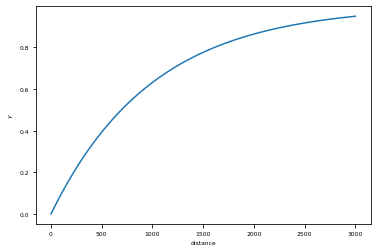

In [13]:
grid_gs.plot()
print("spatial variogram")

'temporal variogram (x axis in days)'

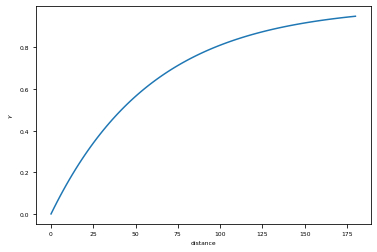

In [14]:
temporal_gs.plot()
"temporal variogram (x axis in days)"

Now let's get the idomain array to use as a zone array - this keeps us from setting up parameters in inactive model cells:

In [15]:
ib = m.dis.idomain[0].array

First, let's setup parameters for static properties - HK, VK, SS, SY.  Do that, we need to find all the external array files that contain these static arrays.  Let's do just HK slowly so as to explain what is happening:

In [16]:
hk_arr_files = [f for f in os.listdir(tmp_model_ws) if "npf_k_" in f and f.endswith(".txt")]
hk_arr_files

['freyberg6.npf_k_layer1.txt',
 'freyberg6.npf_k_layer2.txt',
 'freyberg6.npf_k_layer3.txt']

So those are the existing model input arrays for HK.  Notice we found the files in the temporary model workspace - `PstFrom` will copy all those files to the new model workspace for us in a bit...

Let's setup grid-scale multiplier parameter for HK in layer 1:

In [17]:
pf.add_parameters(filenames="freyberg6.npf_k_layer1.txt",par_type="grid",
                   par_name_base="hk_layer_1",pargp="hk_layer_1",zone_array=ib,
                   upper_bound=10.,lower_bound=0.1,ult_ubound=100,ult_lbound=0.01)


2021-11-20 20:05:23.721434 starting: adding grid type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt']
2021-11-20 20:05:23.722430 starting: loading array freyberg6_template\freyberg6.npf_k_layer1.txt
2021-11-20 20:05:23.742344 finished: loading array freyberg6_template\freyberg6.npf_k_layer1.txt took: 0:00:00.019914
2021-11-20 20:05:23.742344 loaded array 'temp_pst_from\freyberg6.npf_k_layer1.txt' of shape (40, 20)
2021-11-20 20:05:23.747324 starting: writing array-style template file 'freyberg6_template\hk_layer_1_inst0_grid.csv.tpl'
2021-11-20 20:05:23.748320 starting: writing template file freyberg6_template\hk_layer_1_inst0_grid.csv.tpl for ['hk_layer_1_inst:0']
2021-11-20 20:05:23.776201 finished: writing template file freyberg6_template\hk_layer_1_inst0_grid.csv.tpl for ['hk_layer_1_inst:0'] took: 0:00:00.027881
2021-11-20 20:05:23.776201 starting: writing array-based template file 'freyberg6_template\hk_layer_1_inst0_grid.csv.tpl'
2021-11-20 20:05:23.776201 saving z

,parnme,parval1,i,j,x,y,pargp,tpl_filename,input_filename,partype,partrans,parubnd,parlbnd,parchglim,offset,scale,dercom
pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:0_x:125.00_y:9875.00_zone:1,pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:0_x:125.00_y:9875.00_zone:1,1.0,0,0,125.0,9875.0,hk_layer_1,freyberg6_template\hk_layer_1_inst0_grid.csv.tpl,freyberg6_template\mult\hk_layer_1_inst0_grid.csv,grid,log,10.0,0.1,factor,0.0,1.0,1
pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:1_x:375.00_y:9875.00_zone:1,pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:1_x:375.00_y:9875.00_zone:1,1.0,0,1,375.0,9875.0,hk_layer_1,freyberg6_template\hk_layer_1_inst0_grid.csv.tpl,freyberg6_template\mult\hk_layer_1_inst0_grid.csv,grid,log,10.0,0.1,factor,0.0,1.0,1
pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:2_x:625.00_y:9875.00_zone:1,pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:2_x:625.00_y:9875.00_zone:1,1.0,0,2,625.0,9875.0,hk_layer_1,freyberg6_template\hk_layer_1_inst0_grid.csv.tpl,freyberg6_template\mult\hk_layer_1_inst0_grid.csv,grid,log,10.0,0.1,factor,0.0,1.0,1
pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:3_x:875.00_y:9875.00_zone:1,pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:3_x:875.00_y:9875.00_zone:1,1.0,0,3,875.0,9875.0,hk_layer_1,freyberg6_template\hk_layer_1_inst0_grid.csv.tpl,freyberg6_template\mult\hk_layer_1_inst0_grid.csv,grid,log,10.0,0.1,factor,0.0,1.0,1
pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:4_x:1125.00_y:9875.00_zone:1,pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:4_x:1125.00_y:9875.00_zone:1,1.0,0,4,1125.0,9875.0,hk_layer_1,freyberg6_template\hk_layer_1_inst0_grid.csv.tpl,freyberg6_template\mult\hk_layer_1_inst0_grid.csv,grid,log,10.0,0.1,factor,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:39_j:11_x:2875.00_y:125.00_zone:1,pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:39_j:11_x:2875.00_y:125.00_zone:1,1.0,39,11,2875.0,125.0,hk_layer_1,freyberg6_template\hk_layer_1_inst0_grid.csv.tpl,freyberg6_template\mult\hk_layer_1_inst0_grid.csv,grid,log,10.0,0.1,factor,0.0,1.0,1
pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:39_j:12_x:3125.00_y:125.00_zone:1,pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:39_j:12_x:3125.00_y:125.00_zone:1,1.0,39,12,3125.0,125.0,hk_layer_1,freyberg6_template\hk_layer_1_inst0_grid.csv.tpl,freyberg6_template\mult\hk_layer_1_inst0_grid.csv,grid,log,10.0,0.1,factor,0.0,1.0,1
pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:39_j:13_x:3375.00_y:125.00_zone:1,pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:39_j:13_x:3375.00_y:125.00_zone:1,1.0,39,13,3375.0,125.0,hk_layer_1,freyberg6_template\hk_layer_1_inst0_grid.csv.tpl,freyberg6_template\mult\hk_layer_1_inst0_grid.csv,grid,log,10.0,0.1,factor,0.0,1.0,1
pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:39_j:14_x:3625.00_y:125.00_zone:1,pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:39_j:14_x:3625.00_y:125.00_zone:1,1.0,39,14,3625.0,125.0,hk_layer_1,freyberg6_template\hk_layer_1_inst0_grid.csv.tpl,freyberg6_template\mult\hk_layer_1_inst0_grid.csv,grid,log,10.0,0.1,factor,0.0,1.0,1


What just happened there?  Well, we told our `PstFrom` instance to setup a set of grid-scale multiplier parameters (`par_type="grid"`) for the array file "freyberg6.npf_k_layer1.txt". We told it to prefix the parameter names with "hk_layer_1" and also to make the parameter group "hk_layer_1" (`pargp="hk_layer_1"`).  When specified two sets of bound information:  `upper_bound` and `lower_bound` are the standard control file bounds, while `ult_ubound` and `ult_lbound` are bounds that are applied at runtime to the resulting (multiplied out) model input array - since we are using multipliers (and potentially, sets of multipliers - stay tuned), it is important to make sure we keep the resulting model input arrays within the range of realistic values.

If you inspect the contents of the working directory, we will see a new template file:

In [18]:
[f for f in os.listdir(template_ws) if f.endswith(".tpl")]

['hk_layer_1_inst0_grid.csv.tpl']

In [19]:
with open(os.path.join(template_ws,"hk_layer_1_inst0_grid.csv.tpl"),'r') as f:
    for _ in range(2):
        print(f.readline().strip())
        

ptf ~
~   pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:0_x:125.00_y:9875.00_zone:1    ~ ~   pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:1_x:375.00_y:9875.00_zone:1    ~ ~   pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:2_x:625.00_y:9875.00_zone:1    ~ ~   pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:3_x:875.00_y:9875.00_zone:1    ~ ~   pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:4_x:1125.00_y:9875.00_zone:1    ~ ~   pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:5_x:1375.00_y:9875.00_zone:1    ~ ~   pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:6_x:1625.00_y:9875.00_zone:1    ~ ~   pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:7_x:1875.00_y:9875.00_zone:1    ~ ~   pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:8_x:2125.00_y:9875.00_zone:1    ~ ~   pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:9_x:2375.00_y:9875.00_zone:1    ~ ~   pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:10_x:2625.00_y:9875.00_zone:1    ~ ~   pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j


So those might look like pretty redic parameter names, but they contain heaps of metadata to help you post process things later...

## Pilot points in `PstFrom`

You can add pilot points in two ways `PstFrom` can generate them for you on a regular grid or you can supply `PstFrom` with existing pilot point location information.  First lets looks at the regular simple stuf - when you change `par_type` to "pilotpoints", by default, a regular grid of pilot points is setup using a default `pp_space` value of 10, which is every 10th row and column.  We can override this default like:

In [20]:
pf.add_parameters(filenames="freyberg6.npf_k_layer3.txt",par_type="pilotpoints",
                   par_name_base="hk_layer_1",pargp="hk_layer_1",zone_array=ib,
                   upper_bound=10.,lower_bound=0.1,ult_ubound=100,ult_lbound=0.01,
                   pp_space=5)

2021-11-20 20:05:23.860873 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer3.txt']
2021-11-20 20:05:23.861869 starting: loading array freyberg6_template\freyberg6.npf_k_layer3.txt
2021-11-20 20:05:23.881784 finished: loading array freyberg6_template\freyberg6.npf_k_layer3.txt took: 0:00:00.019915
2021-11-20 20:05:23.882777 loaded array 'temp_pst_from\freyberg6.npf_k_layer3.txt' of shape (40, 20)
2021-11-20 20:05:23.884772 starting: writing array-style template file 'freyberg6_template\hk_layer_1_inst1_pilotpoints.csv.tpl'
2021-11-20 20:05:23.885770 starting: setting up pilot point parameters
2021-11-20 20:05:23.885770 No spatial reference (containing cell spacing) passed.
2021-11-20 20:05:23.885770 OK - using spatial reference in parent object.
2021-11-20 20:05:23.885770 WARNING: pp_geostruct is None,using ExpVario with contribution=1 and a=(pp_space*max(delr,delc))
2021-11-20 20:05:24.004107 29 pilot point parameters created
2021-11-20 20:05:24.

D:\modelling\pyemu\pyemu\logger.py:100: PyemuWarning: 2021-11-20 20:05:23.885770 WARNING: pp_geostruct is None,using ExpVario with contribution=1 and a=(pp_space*max(delr,delc))



starting 0
starting 1
starting 2
starting 3
starting 4
starting 5
starting 6
starting 7
starting 8
starting 9
took 3.935297 seconds
2021-11-20 20:05:28.044350 finished: calculating factors for pargp=hk_layer_1 took: 0:00:04.019367
2021-11-20 20:05:28.044350 starting: writing array-based template file 'freyberg6_template\hk_layer_1_inst1pp.dat.tpl'
2021-11-20 20:05:28.044350 saving zone array freyberg6_template\hk_layer_1_inst1pp.dat.zone for tpl file freyberg6_template\hk_layer_1_inst1pp.dat.tpl
2021-11-20 20:05:28.044350 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer3.txt'] took: 0:00:04.183477


,name,x,y,zone,parval1,k,i,j,parnme,tpl,...,pp_filename,pargp,partrans,parchglim,parlbnd,parubnd,scale,offset,dercom,partype
parnme,,,,,,,,,,,,,,,,,,,,,
pname:hk_layer_1_inst:1_ptype:pp_pstyle:m_i:2_j:2_zone:1.0,pp_0000,625.0,9375.0,1.0,1.0,0,2,2,pname:hk_layer_1_inst:1_ptype:pp_pstyle:m_i:2_j:2_zone:1.0,~ pname:hk_layer_1_inst:1_ptype:pp_pstyle:m_i:2_j:2_zone:1.0 ~,...,freyberg6_template\hk_layer_1_inst1pp.dat,hk_layer_1,log,factor,0.1,10.0,1.0,0.0,1,pilotpoints
pname:hk_layer_1_inst:1_ptype:pp_pstyle:m_i:2_j:7_zone:1.0,pp_0001,1875.0,9375.0,1.0,1.0,0,2,7,pname:hk_layer_1_inst:1_ptype:pp_pstyle:m_i:2_j:7_zone:1.0,~ pname:hk_layer_1_inst:1_ptype:pp_pstyle:m_i:2_j:7_zone:1.0 ~,...,freyberg6_template\hk_layer_1_inst1pp.dat,hk_layer_1,log,factor,0.1,10.0,1.0,0.0,1,pilotpoints
pname:hk_layer_1_inst:1_ptype:pp_pstyle:m_i:2_j:12_zone:1.0,pp_0002,3125.0,9375.0,1.0,1.0,0,2,12,pname:hk_layer_1_inst:1_ptype:pp_pstyle:m_i:2_j:12_zone:1.0,~ pname:hk_layer_1_inst:1_ptype:pp_pstyle:m_i:2_j:12_zone:1.0 ~,...,freyberg6_template\hk_layer_1_inst1pp.dat,hk_layer_1,log,factor,0.1,10.0,1.0,0.0,1,pilotpoints
pname:hk_layer_1_inst:1_ptype:pp_pstyle:m_i:2_j:17_zone:1.0,pp_0003,4375.0,9375.0,1.0,1.0,0,2,17,pname:hk_layer_1_inst:1_ptype:pp_pstyle:m_i:2_j:17_zone:1.0,~ pname:hk_layer_1_inst:1_ptype:pp_pstyle:m_i:2_j:17_zone:1.0 ~,...,freyberg6_template\hk_layer_1_inst1pp.dat,hk_layer_1,log,factor,0.1,10.0,1.0,0.0,1,pilotpoints
pname:hk_layer_1_inst:1_ptype:pp_pstyle:m_i:7_j:2_zone:1.0,pp_0004,625.0,8125.0,1.0,1.0,0,7,2,pname:hk_layer_1_inst:1_ptype:pp_pstyle:m_i:7_j:2_zone:1.0,~ pname:hk_layer_1_inst:1_ptype:pp_pstyle:m_i:7_j:2_zone:1.0 ~,...,freyberg6_template\hk_layer_1_inst1pp.dat,hk_layer_1,log,factor,0.1,10.0,1.0,0.0,1,pilotpoints
pname:hk_layer_1_inst:1_ptype:pp_pstyle:m_i:7_j:7_zone:1.0,pp_0005,1875.0,8125.0,1.0,1.0,0,7,7,pname:hk_layer_1_inst:1_ptype:pp_pstyle:m_i:7_j:7_zone:1.0,~ pname:hk_layer_1_inst:1_ptype:pp_pstyle:m_i:7_j:7_zone:1.0 ~,...,freyberg6_template\hk_layer_1_inst1pp.dat,hk_layer_1,log,factor,0.1,10.0,1.0,0.0,1,pilotpoints
pname:hk_layer_1_inst:1_ptype:pp_pstyle:m_i:7_j:12_zone:1.0,pp_0006,3125.0,8125.0,1.0,1.0,0,7,12,pname:hk_layer_1_inst:1_ptype:pp_pstyle:m_i:7_j:12_zone:1.0,~ pname:hk_layer_1_inst:1_ptype:pp_pstyle:m_i:7_j:12_zone:1.0 ~,...,freyberg6_template\hk_layer_1_inst1pp.dat,hk_layer_1,log,factor,0.1,10.0,1.0,0.0,1,pilotpoints
pname:hk_layer_1_inst:1_ptype:pp_pstyle:m_i:7_j:17_zone:1.0,pp_0007,4375.0,8125.0,1.0,1.0,0,7,17,pname:hk_layer_1_inst:1_ptype:pp_pstyle:m_i:7_j:17_zone:1.0,~ pname:hk_layer_1_inst:1_ptype:pp_pstyle:m_i:7_j:17_zone:1.0 ~,...,freyberg6_template\hk_layer_1_inst1pp.dat,hk_layer_1,log,factor,0.1,10.0,1.0,0.0,1,pilotpoints
pname:hk_layer_1_inst:1_ptype:pp_pstyle:m_i:12_j:2_zone:1.0,pp_0008,625.0,6875.0,1.0,1.0,0,12,2,pname:hk_layer_1_inst:1_ptype:pp_pstyle:m_i:12_j:2_zone:1.0,~ pname:hk_layer_1_inst:1_ptype:pp_pstyle:m_i:12_j:2_zone:1.0 ~,...,freyberg6_template\hk_layer_1_inst1pp.dat,hk_layer_1,log,factor,0.1,10.0,1.0,0.0,1,pilotpoints


Now lets look at how to supply existing pilot locations - to do this, we simply change the `pp_space` arg to a filename or a dataframe.  The dataframe must have "name", "x", and "y" as columns - it can have more, but must have those.  If you supply `pp_space` as an `str` it is assumed to be a filename the extension is the guide: ".csv" for dataframe, ".shp" for shapefile (point-type) and everything else is assumed to be a pilot points file type. For example, here it is with a shapefile - first we will just make up some random pilot point locations and write those to a shapefile:

In [21]:
xmn = m.modelgrid.xvertices.min()
xmx = m.modelgrid.xvertices.max()
ymn = m.modelgrid.yvertices.min()
ymx = m.modelgrid.yvertices.max()

numpp = 20
xvals = np.random.uniform(xmn,xmx,numpp)
yvals = np.random.uniform(ymn, ymx, numpp)
pp_locs = pd.DataFrame({"x":xvals,"y":yvals})
pp_locs.loc[:,"zone"] = 1
pp_locs.loc[:,"name"] = ["pp_{0}".format(i) for i in range(numpp)]
pp_locs.loc[:,"parval1"] = 1.0

pyemu.pp_utils.write_pp_shapfile(pp_locs,os.path.join(template_ws,"pp_locs.shp"))

D:\modelling\pyemu\pyemu\utils\pp_utils.py:449: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
D:\modelling\pyemu\pyemu\utils\pp_utils.py:449: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details

Normally, you would probably put more thought in to pilot point locations, or maybe not!  Now we call `add_parameters` and just pass the shapefile name for `pp_space`:

In [22]:
pf.add_parameters(filenames="freyberg6.npf_k_layer2.txt",par_type="pilotpoints",
                   par_name_base="hk_layer_1",pargp="hk_layer_1",zone_array=ib,
                   upper_bound=10.,lower_bound=0.1,ult_ubound=100,ult_lbound=0.01,
                   pp_space="pp_locs.shp")

2021-11-20 20:05:28.137956 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer2.txt']
2021-11-20 20:05:28.137956 starting: loading array freyberg6_template\freyberg6.npf_k_layer2.txt
2021-11-20 20:05:28.158914 finished: loading array freyberg6_template\freyberg6.npf_k_layer2.txt took: 0:00:00.020958
2021-11-20 20:05:28.158914 loaded array 'temp_pst_from\freyberg6.npf_k_layer2.txt' of shape (40, 20)
2021-11-20 20:05:28.161908 starting: writing array-style template file 'freyberg6_template\hk_layer_1_inst2_pilotpoints.csv.tpl'
2021-11-20 20:05:28.161908 starting: setting up pilot point parameters
2021-11-20 20:05:28.161908 No spatial reference (containing cell spacing) passed.
2021-11-20 20:05:28.161908 OK - using spatial reference in parent object.
2021-11-20 20:05:28.161908 trying to load pilot point location info from shapefile 'freyberg6_template\pp_locs.shp'
2021-11-20 20:05:28.170867 pilot points found in file 'pp_locs.shp' will be transferred t

D:\modelling\pyemu\pyemu\logger.py:100: PyemuWarning: 2021-11-20 20:05:28.170867 WARNING: pp_geostruct is None,using ExpVario with contribution=1 and a=(pp_space*max(delr,delc))



2021-11-20 20:05:28.170867 WARNING: pp_geostruct is None,using ExpVario with contribution=1 and a=(pp_space*max(delr,delc))
2021-11-20 20:05:28.170867 20 pilot point parameters created
2021-11-20 20:05:28.170867 pilot point 'pargp':hk_layer_1
2021-11-20 20:05:28.170867 finished: setting up pilot point parameters took: 0:00:00.008959
2021-11-20 20:05:28.201329 starting: calculating factors for pargp=hk_layer_1
2021-11-20 20:05:28.201329 saving krige variance file:freyberg6_template\hk_layer_1_inst2pp.var.dat
2021-11-20 20:05:28.201329 saving krige factors file:freyberg6_template\hk_layer_1_inst2pp.fac
starting interp point loop for 706 points
starting 0
starting 1
starting 2
starting 3
starting 4
starting 5
starting 6
starting 7
starting 8
starting 9
took 3.934968 seconds
2021-11-20 20:05:32.188267 finished: calculating factors for pargp=hk_layer_1 took: 0:00:03.986938
2021-11-20 20:05:32.188267 starting: writing array-based template file 'freyberg6_template\hk_layer_1_inst2pp.dat.tpl'


,x,y,zone,name,parval1,parnme,tpl,pargp,partype,partrans,parubnd,parlbnd,parchglim,offset,scale,dercom
parnme,,,,,,,,,,,,,,,,
pname:hk_layer_1_inst:2_ptype:pp_pstyle:m_x:730.60_y:3096.48_zone:1,730.604939,3096.477105,1,pp_0,1.0,pname:hk_layer_1_inst:2_ptype:pp_pstyle:m_x:730.60_y:3096.48_zone:1,~ pname:hk_layer_1_inst:2_ptype:pp_pstyle:m_x:730.60_y:3096.48_zone:1 ~,hk_layer_1,pilotpoints,log,10.0,0.1,factor,0.0,1.0,1
pname:hk_layer_1_inst:2_ptype:pp_pstyle:m_x:1293.02_y:8202.98_zone:1,1293.019448,8202.982152,1,pp_1,1.0,pname:hk_layer_1_inst:2_ptype:pp_pstyle:m_x:1293.02_y:8202.98_zone:1,~ pname:hk_layer_1_inst:2_ptype:pp_pstyle:m_x:1293.02_y:8202.98_zone:1 ~,hk_layer_1,pilotpoints,log,10.0,0.1,factor,0.0,1.0,1
pname:hk_layer_1_inst:2_ptype:pp_pstyle:m_x:650.78_y:3896.53_zone:1,650.777771,3896.526509,1,pp_2,1.0,pname:hk_layer_1_inst:2_ptype:pp_pstyle:m_x:650.78_y:3896.53_zone:1,~ pname:hk_layer_1_inst:2_ptype:pp_pstyle:m_x:650.78_y:3896.53_zone:1 ~,hk_layer_1,pilotpoints,log,10.0,0.1,factor,0.0,1.0,1
pname:hk_layer_1_inst:2_ptype:pp_pstyle:m_x:4014.79_y:5846.47_zone:1,4014.790941,5846.466586,1,pp_3,1.0,pname:hk_layer_1_inst:2_ptype:pp_pstyle:m_x:4014.79_y:5846.47_zone:1,~ pname:hk_layer_1_inst:2_ptype:pp_pstyle:m_x:4014.79_y:5846.47_zone:1 ~,hk_layer_1,pilotpoints,log,10.0,0.1,factor,0.0,1.0,1
pname:hk_layer_1_inst:2_ptype:pp_pstyle:m_x:1455.88_y:2799.44_zone:1,1455.876156,2799.436265,1,pp_4,1.0,pname:hk_layer_1_inst:2_ptype:pp_pstyle:m_x:1455.88_y:2799.44_zone:1,~ pname:hk_layer_1_inst:2_ptype:pp_pstyle:m_x:1455.88_y:2799.44_zone:1 ~,hk_layer_1,pilotpoints,log,10.0,0.1,factor,0.0,1.0,1
pname:hk_layer_1_inst:2_ptype:pp_pstyle:m_x:3552.07_y:5409.28_zone:1,3552.072510,5409.275192,1,pp_5,1.0,pname:hk_layer_1_inst:2_ptype:pp_pstyle:m_x:3552.07_y:5409.28_zone:1,~ pname:hk_layer_1_inst:2_ptype:pp_pstyle:m_x:3552.07_y:5409.28_zone:1 ~,hk_layer_1,pilotpoints,log,10.0,0.1,factor,0.0,1.0,1
pname:hk_layer_1_inst:2_ptype:pp_pstyle:m_x:1888.00_y:672.23_zone:1,1887.999811,672.230344,1,pp_6,1.0,pname:hk_layer_1_inst:2_ptype:pp_pstyle:m_x:1888.00_y:672.23_zone:1,~ pname:hk_layer_1_inst:2_ptype:pp_pstyle:m_x:1888.00_y:672.23_zone:1 ~,hk_layer_1,pilotpoints,log,10.0,0.1,factor,0.0,1.0,1
pname:hk_layer_1_inst:2_ptype:pp_pstyle:m_x:4585.15_y:7402.06_zone:1,4585.151838,7402.055491,1,pp_7,1.0,pname:hk_layer_1_inst:2_ptype:pp_pstyle:m_x:4585.15_y:7402.06_zone:1,~ pname:hk_layer_1_inst:2_ptype:pp_pstyle:m_x:4585.15_y:7402.06_zone:1 ~,hk_layer_1,pilotpoints,log,10.0,0.1,factor,0.0,1.0,1
pname:hk_layer_1_inst:2_ptype:pp_pstyle:m_x:22.86_y:2700.21_zone:1,22.861139,2700.205730,1,pp_8,1.0,pname:hk_layer_1_inst:2_ptype:pp_pstyle:m_x:22.86_y:2700.21_zone:1,~ pname:hk_layer_1_inst:2_ptype:pp_pstyle:m_x:22.86_y:2700.21_zone:1 ~,hk_layer_1,pilotpoints,log,10.0,0.1,factor,0.0,1.0,1




## Extra pre- and post-processing functions

You will also certainly need to include some additional processing steps.  These are supported thru the `PstFrom.pre_py cmds` and `PstFrom.post_py_cmds`, which are lists for pre and post model run python commands and `PstFrom.pre_sys_cmds` and `PstFrom.post_sys_cmds`, which are lists for pre and post model run system commands (these are wrapped in `pyemu.os_utils.run()`.  But what if your additional steps are actually an entire python function? Well, we got that too! `PstFrom.add_py_function()`. For example, let's say you have a post processing function called `process_model_outputs()` in a python source file called `helpers.py`:

In [23]:
_ = [print(line.rstrip()) for line in open("helpers.py",'r').readlines()]

import os
import pyemu

def process_model_outputs():
	import numpy as np
	print("processing model outputs")
	arr = np.random.random(100)
	np.savetxt("special_outputs.dat",arr)
	return arr


def write_ins_file(d):
	cwd = os.getcwd()
	os.chdir(d)
	arr = process_model_outputs()
	os.chdir(cwd)
	with open(os.path.join(d,"special_outputs.dat.ins"),'w') as f:
		f.write("pif ~\n")
		for i in range(arr.shape[0]):
			f.write("l1 !sobs_{0}!\n".format(i))


	i = pyemu.pst_utils.InstructionFile(os.path.join(d,"special_outputs.dat.ins"))
	df = i.read_output_file("special_outputs.dat")

	return df


if __name__ == "__main__":
	#process_model_outputs()
	write_ins_file(".")



We see that the file `helpers.py` contains two functions (could be more..).  We want to call `process_model_outputs()` each time pest(++) runs the model as a post processing function.  This function will yield some quantities that we want to record with an instruction.  So, first, we can call the function `write_ins_file()` in `helpers.py` to build the instruction file for the special processed outputs that `process_model_outputs()` will produce (in this trivial example, `process_model_outputs()` just generates random numbers...).  Note that the instruction file needs to be in the `template_ws` directory since it is a pest interface file.

Lets make sure our new instruction file exists...

In [24]:
assert os.path.exists("special_outputs.dat.ins")
special_ins_filename = os.path.join(template_ws,"special_outputs.dat.ins")
shutil.copy2("special_outputs.dat.ins",special_ins_filename)

'freyberg6_template\\special_outputs.dat.ins'

First, we can add the function `process_model_outputs()` to the forward run script like this:

In [25]:
pf.add_py_function("helpers.py","process_model_outputs()",is_pre_cmd=False)

This will copy the function `process_model_outputs()` from `helpers.py` into the forward run script that `PstFrom` will write. But we still need to add the instruction file into the mix - lets do that! 

In [26]:
out_file = special_ins_filename.replace(".ins","")
pf.add_observations_from_ins(ins_file=special_ins_filename,out_file=out_file,pst_path=".")

2021-11-20 20:05:32.283844 starting: adding observation from instruction file 'freyberg6_template\special_outputs.dat.ins'
error processing instruction/output file pair: output file 'freyberg6_template\special_outputs.dat' not found
2021-11-20 20:05:32.293838 finished: adding observation from instruction file 'freyberg6_template\special_outputs.dat.ins' took: 0:00:00.009994


,obsnme,obsval,weight,obgnme
sobs_0,sobs_0,1.000000e+10,1.0,obgnme
sobs_1,sobs_1,1.000000e+10,1.0,obgnme
sobs_10,sobs_10,1.000000e+10,1.0,obgnme
sobs_11,sobs_11,1.000000e+10,1.0,obgnme
sobs_12,sobs_12,1.000000e+10,1.0,obgnme
...,...,...,...,...
sobs_95,sobs_95,1.000000e+10,1.0,obgnme
sobs_96,sobs_96,1.000000e+10,1.0,obgnme
sobs_97,sobs_97,1.000000e+10,1.0,obgnme
sobs_98,sobs_98,1.000000e+10,1.0,obgnme


that `pst_path` argument tells `PstFrom` that the instruction file will be in the directory where pest(++) is running

### build the control file, pest interface files, and forward run script
At this point, we have some parameters and some observations, so we can create a control file:

In [27]:
pst = pf.build_pst()

noptmax:0, npar_adj:755, nnz_obs:825


Oh snap! we did it!  thanks for playing...

Well, there is a little more to the story.  Like how do we run this thing? Lucky for you, `PstFrom` writes a forward run script for you! Say Wat?!

In [28]:
[f for f in os.listdir(template_ws) if f.endswith(".py")]

['forward_run.py']

In [29]:
_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

import os
import multiprocessing as mp
import numpy as np
import pandas as pd
import pyemu

# function added thru PstFrom.add_py_function()
def process_model_outputs():
	import numpy as np
	print("processing model outputs")
	arr = np.random.random(100)
	np.savetxt("special_outputs.dat",arr)
	return arr



def main():

    try:
       os.remove(r'heads.csv')
    except Exception as e:
       print(r'error removing tmp file:heads.csv')
    try:
       os.remove(r'sfr.csv')
    except Exception as e:
       print(r'error removing tmp file:sfr.csv')
    try:
       os.remove(r'special_outputs.dat')
    except Exception as e:
       print(r'error removing tmp file:special_outputs.dat')
    pyemu.helpers.apply_list_and_array_pars(arr_par_file='mult2model_info.csv',chunk_len=50)
    process_model_outputs()

if __name__ == '__main__':
    mp.freeze_support()
    main()



Not bad! We have everything we need, including our special post processing function...except we didnt set a command to run the model! Doh!  

Let's add that:

In [30]:
# only execute this block once!
pf.mod_sys_cmds.append("mf6")
pst = pf.build_pst()


noptmax:0, npar_adj:755, nnz_obs:825
2021-11-20 20:05:32.673552 forward_run line:pyemu.os_utils.run(r'mf6')



In [31]:
_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

import os
import multiprocessing as mp
import numpy as np
import pandas as pd
import pyemu

# function added thru PstFrom.add_py_function()
def process_model_outputs():
	import numpy as np
	print("processing model outputs")
	arr = np.random.random(100)
	np.savetxt("special_outputs.dat",arr)
	return arr



def main():

    try:
       os.remove(r'heads.csv')
    except Exception as e:
       print(r'error removing tmp file:heads.csv')
    try:
       os.remove(r'sfr.csv')
    except Exception as e:
       print(r'error removing tmp file:sfr.csv')
    try:
       os.remove(r'special_outputs.dat')
    except Exception as e:
       print(r'error removing tmp file:special_outputs.dat')
    pyemu.helpers.apply_list_and_array_pars(arr_par_file='mult2model_info.csv',chunk_len=50)
    pyemu.os_utils.run(r'mf6')

    process_model_outputs()

if __name__ == '__main__':
    mp.freeze_support()
    main()



That's better!  See the `pyemu.os_utils.run(r'mf6')` line in `main()`?  

We also see that we now have a function called `process_model_outputs()` added to the forward run script and the function is being called after the model run call.



## Generating geostatistical prior covariance matrices and ensembles

So that's nice, but how do we include spatial correlation in these parameters?  It simple: just pass the `geostruct` arg to `PstFrom.add_parameters()`

In [32]:
pf.add_parameters(filenames="freyberg6.npf_k_layer3.txt",par_type="grid",
                   par_name_base="hk_layer_3",pargp="hk_layer_3",zone_array=ib,
                   upper_bound=10.,lower_bound=0.1,ult_ubound=100,ult_lbound=0.01,
                 geostruct=grid_gs)


2021-11-20 20:05:32.743677 starting: adding grid type m style parameters for file(s) ['freyberg6.npf_k_layer3.txt']
2021-11-20 20:05:32.743677 starting: loading array freyberg6_template\freyberg6.npf_k_layer3.txt
2021-11-20 20:05:32.745662 finished: loading array freyberg6_template\freyberg6.npf_k_layer3.txt took: 0:00:00.001985
2021-11-20 20:05:32.746657 loaded array 'temp_pst_from\freyberg6.npf_k_layer3.txt' of shape (40, 20)
2021-11-20 20:05:32.748649 starting: writing array-style template file 'freyberg6_template\hk_layer_3_inst0_grid.csv.tpl'
2021-11-20 20:05:32.748649 starting: writing template file freyberg6_template\hk_layer_3_inst0_grid.csv.tpl for ['hk_layer_3_inst:0']
2021-11-20 20:05:32.763127 finished: writing template file freyberg6_template\hk_layer_3_inst0_grid.csv.tpl for ['hk_layer_3_inst:0'] took: 0:00:00.014478
2021-11-20 20:05:32.763127 starting: writing array-based template file 'freyberg6_template\hk_layer_3_inst0_grid.csv.tpl'
2021-11-20 20:05:32.763127 saving z

,parnme,parval1,i,j,x,y,pargp,tpl_filename,input_filename,partype,partrans,parubnd,parlbnd,parchglim,offset,scale,dercom
pname:hk_layer_3_inst:0_ptype:gr_pstyle:m_i:0_j:0_x:125.00_y:9875.00_zone:1,pname:hk_layer_3_inst:0_ptype:gr_pstyle:m_i:0_j:0_x:125.00_y:9875.00_zone:1,1.0,0,0,125.0,9875.0,hk_layer_3,freyberg6_template\hk_layer_3_inst0_grid.csv.tpl,freyberg6_template\mult\hk_layer_3_inst0_grid.csv,grid,log,10.0,0.1,factor,0.0,1.0,1
pname:hk_layer_3_inst:0_ptype:gr_pstyle:m_i:0_j:1_x:375.00_y:9875.00_zone:1,pname:hk_layer_3_inst:0_ptype:gr_pstyle:m_i:0_j:1_x:375.00_y:9875.00_zone:1,1.0,0,1,375.0,9875.0,hk_layer_3,freyberg6_template\hk_layer_3_inst0_grid.csv.tpl,freyberg6_template\mult\hk_layer_3_inst0_grid.csv,grid,log,10.0,0.1,factor,0.0,1.0,1
pname:hk_layer_3_inst:0_ptype:gr_pstyle:m_i:0_j:2_x:625.00_y:9875.00_zone:1,pname:hk_layer_3_inst:0_ptype:gr_pstyle:m_i:0_j:2_x:625.00_y:9875.00_zone:1,1.0,0,2,625.0,9875.0,hk_layer_3,freyberg6_template\hk_layer_3_inst0_grid.csv.tpl,freyberg6_template\mult\hk_layer_3_inst0_grid.csv,grid,log,10.0,0.1,factor,0.0,1.0,1
pname:hk_layer_3_inst:0_ptype:gr_pstyle:m_i:0_j:3_x:875.00_y:9875.00_zone:1,pname:hk_layer_3_inst:0_ptype:gr_pstyle:m_i:0_j:3_x:875.00_y:9875.00_zone:1,1.0,0,3,875.0,9875.0,hk_layer_3,freyberg6_template\hk_layer_3_inst0_grid.csv.tpl,freyberg6_template\mult\hk_layer_3_inst0_grid.csv,grid,log,10.0,0.1,factor,0.0,1.0,1
pname:hk_layer_3_inst:0_ptype:gr_pstyle:m_i:0_j:4_x:1125.00_y:9875.00_zone:1,pname:hk_layer_3_inst:0_ptype:gr_pstyle:m_i:0_j:4_x:1125.00_y:9875.00_zone:1,1.0,0,4,1125.0,9875.0,hk_layer_3,freyberg6_template\hk_layer_3_inst0_grid.csv.tpl,freyberg6_template\mult\hk_layer_3_inst0_grid.csv,grid,log,10.0,0.1,factor,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pname:hk_layer_3_inst:0_ptype:gr_pstyle:m_i:39_j:11_x:2875.00_y:125.00_zone:1,pname:hk_layer_3_inst:0_ptype:gr_pstyle:m_i:39_j:11_x:2875.00_y:125.00_zone:1,1.0,39,11,2875.0,125.0,hk_layer_3,freyberg6_template\hk_layer_3_inst0_grid.csv.tpl,freyberg6_template\mult\hk_layer_3_inst0_grid.csv,grid,log,10.0,0.1,factor,0.0,1.0,1
pname:hk_layer_3_inst:0_ptype:gr_pstyle:m_i:39_j:12_x:3125.00_y:125.00_zone:1,pname:hk_layer_3_inst:0_ptype:gr_pstyle:m_i:39_j:12_x:3125.00_y:125.00_zone:1,1.0,39,12,3125.0,125.0,hk_layer_3,freyberg6_template\hk_layer_3_inst0_grid.csv.tpl,freyberg6_template\mult\hk_layer_3_inst0_grid.csv,grid,log,10.0,0.1,factor,0.0,1.0,1
pname:hk_layer_3_inst:0_ptype:gr_pstyle:m_i:39_j:13_x:3375.00_y:125.00_zone:1,pname:hk_layer_3_inst:0_ptype:gr_pstyle:m_i:39_j:13_x:3375.00_y:125.00_zone:1,1.0,39,13,3375.0,125.0,hk_layer_3,freyberg6_template\hk_layer_3_inst0_grid.csv.tpl,freyberg6_template\mult\hk_layer_3_inst0_grid.csv,grid,log,10.0,0.1,factor,0.0,1.0,1
pname:hk_layer_3_inst:0_ptype:gr_pstyle:m_i:39_j:14_x:3625.00_y:125.00_zone:1,pname:hk_layer_3_inst:0_ptype:gr_pstyle:m_i:39_j:14_x:3625.00_y:125.00_zone:1,1.0,39,14,3625.0,125.0,hk_layer_3,freyberg6_template\hk_layer_3_inst0_grid.csv.tpl,freyberg6_template\mult\hk_layer_3_inst0_grid.csv,grid,log,10.0,0.1,factor,0.0,1.0,1


let's also check out the super awesome prior parameter covariance matrix and prior parameter ensemble helpers in `PstFrom`:

noptmax:0, npar_adj:1461, nnz_obs:825
2021-11-20 20:05:32.994860 WARNING: sys_cmd 'pyemu.os_utils.run(r'mf6')
' already in sys cmds, skipping...
2021-11-20 20:05:33.092688 starting: building prior covariance matrix


D:\modelling\pyemu\pyemu\logger.py:100: PyemuWarning: 2021-11-20 20:05:32.994860 WARNING: sys_cmd 'pyemu.os_utils.run(r'mf6')
' already in sys cmds, skipping...



2021-11-20 20:05:33.387933 saving prior covariance matrix to file freyberg6_template\temp_pst_from.prior.cov
2021-11-20 20:05:34.525816 finished: building prior covariance matrix took: 0:00:01.433128


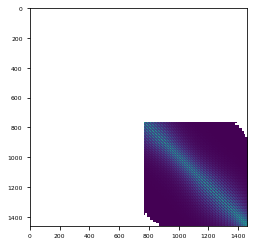

In [33]:
pst = pf.build_pst()
cov = pf.build_prior()
x = cov.x.copy()
x[x<0.00001] = np.NaN
plt.imshow(x)

Da-um!  that's sweet ez!  We can see the first block of HK parameters in the upper left as "uncorrelated" (diagonal only) entries, then the second block of HK parameters (lower right) that are spatially correlated.

### List file parameterization

Let's add parameters for well extraction rates (always uncertain, rarely estimated!)

In [34]:
wel_files = [f for f in os.listdir(tmp_model_ws) if "wel_stress_period" in f and f.endswith(".txt")]
wel_files

['freyberg6.wel_stress_period_data_1.txt',
 'freyberg6.wel_stress_period_data_10.txt',
 'freyberg6.wel_stress_period_data_11.txt',
 'freyberg6.wel_stress_period_data_12.txt',
 'freyberg6.wel_stress_period_data_13.txt',
 'freyberg6.wel_stress_period_data_14.txt',
 'freyberg6.wel_stress_period_data_15.txt',
 'freyberg6.wel_stress_period_data_16.txt',
 'freyberg6.wel_stress_period_data_17.txt',
 'freyberg6.wel_stress_period_data_18.txt',
 'freyberg6.wel_stress_period_data_19.txt',
 'freyberg6.wel_stress_period_data_2.txt',
 'freyberg6.wel_stress_period_data_20.txt',
 'freyberg6.wel_stress_period_data_21.txt',
 'freyberg6.wel_stress_period_data_22.txt',
 'freyberg6.wel_stress_period_data_23.txt',
 'freyberg6.wel_stress_period_data_24.txt',
 'freyberg6.wel_stress_period_data_25.txt',
 'freyberg6.wel_stress_period_data_3.txt',
 'freyberg6.wel_stress_period_data_4.txt',
 'freyberg6.wel_stress_period_data_5.txt',
 'freyberg6.wel_stress_period_data_6.txt',
 'freyberg6.wel_stress_period_data_7.t

In [35]:
pd.read_csv(os.path.join(tmp_model_ws,wel_files[0]),header=None)

,0
0,3 10 17 -175.00000000
1,3 12 14 -175.00000000
2,3 21 15 -175.00000000
3,3 27 11 -175.00000000
4,3 30 7 -175.00000000
5,3 35 13 -175.00000000


There are several ways to approach wel file parameterization.  One way is to add a constant multiplier parameter for each stress period (that is, one scaling parameter that is applied all active wells for each stress period).  Let's see how that looks, but first one important point:  If you use the same parameter group name (`pargp`) and same geostruct, the `PstFrom` will treat parameters setup across different calls to `add_parameters()` as correlated.  In this case, we want to express temporal correlation in the well multiplier pars, so we use the same parameter group names, specify the `datetime` and `geostruct` args.

In [36]:
# build up a container of stress period start datetimes - this will
# be used to specify the datetime of each multipler parameter
dts = pd.to_datetime(pf.start_datetime) + pd.to_timedelta(np.cumsum(sim.tdis.perioddata.array["perlen"]),unit='d')

for wel_file in wel_files:
    # get the stress period number from the file name
    kper = int(wel_file.split('.')[1].split('_')[-1]) - 1  
    pf.add_parameters(filenames=wel_file,par_type="constant",par_name_base="wel_cn",
                     pargp="wel_cn", upper_bound = 1.5, lower_bound=0.5,
                     datetime=dts[kper],geostruct=temporal_gs)

2021-11-20 20:05:35.013212 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_1.txt']
2021-11-20 20:05:35.013212 WARNING: 0) Inconsistency between geostruct transform and partrans.
2021-11-20 20:05:35.013212 WARNING: 1) Setting geostruct transform to {transform}
2021-11-20 20:05:35.013212 WARNING: -) Better to pass an appropriately transformed geostruct
2021-11-20 20:05:35.013212 starting: loading array freyberg6_template\freyberg6.wel_stress_period_data_1.txt
2021-11-20 20:05:35.013212 finished: loading array freyberg6_template\freyberg6.wel_stress_period_data_1.txt took: 0:00:00
2021-11-20 20:05:35.013212 loaded array 'temp_pst_from\freyberg6.wel_stress_period_data_1.txt' of shape (6, 4)
2021-11-20 20:05:35.013212 starting: writing array-style template file 'freyberg6_template\wel_cn_inst0_constant.csv.tpl'
2021-11-20 20:05:35.013212 starting: writing template file freyberg6_template\wel_cn_inst0_constant.csv.tpl for ['wel_cn_inst:0']
202

D:\modelling\pyemu\pyemu\logger.py:100: PyemuWarning: 2021-11-20 20:05:35.013212 WARNING: 0) Inconsistency between geostruct transform and partrans.

D:\modelling\pyemu\pyemu\logger.py:100: PyemuWarning: 2021-11-20 20:05:35.013212 WARNING: 1) Setting geostruct transform to {transform}

D:\modelling\pyemu\pyemu\logger.py:100: PyemuWarning: 2021-11-20 20:05:35.013212 WARNING: -) Better to pass an appropriately transformed geostruct



2021-11-20 20:05:35.201669 finished: loading array freyberg6_template\freyberg6.wel_stress_period_data_20.txt took: 0:00:00.016626
2021-11-20 20:05:35.201669 loaded array 'temp_pst_from\freyberg6.wel_stress_period_data_20.txt' of shape (6, 4)
2021-11-20 20:05:35.201669 starting: writing array-style template file 'freyberg6_template\wel_cn_inst12_constant.csv.tpl'
2021-11-20 20:05:35.201669 starting: writing template file freyberg6_template\wel_cn_inst12_constant.csv.tpl for ['wel_cn_inst:12']
2021-11-20 20:05:35.201669 finished: writing template file freyberg6_template\wel_cn_inst12_constant.csv.tpl for ['wel_cn_inst:12'] took: 0:00:00
2021-11-20 20:05:35.201669 starting: writing array-based template file 'freyberg6_template\wel_cn_inst12_constant.csv.tpl'
2021-11-20 20:05:35.215545 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_20.txt'] took: 0:00:00.030502
2021-11-20 20:05:35.216539 starting: adding constant type m style parameters fo

2021-11-20 20:05:35.388088 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_9.txt']
2021-11-20 20:05:35.388088 starting: loading array freyberg6_template\freyberg6.wel_stress_period_data_9.txt
2021-11-20 20:05:35.388088 finished: loading array freyberg6_template\freyberg6.wel_stress_period_data_9.txt took: 0:00:00
2021-11-20 20:05:35.388088 loaded array 'temp_pst_from\freyberg6.wel_stress_period_data_9.txt' of shape (6, 4)
2021-11-20 20:05:35.388088 starting: writing array-style template file 'freyberg6_template\wel_cn_inst24_constant.csv.tpl'
2021-11-20 20:05:35.388088 starting: writing template file freyberg6_template\wel_cn_inst24_constant.csv.tpl for ['wel_cn_inst:24']
2021-11-20 20:05:35.397282 finished: writing template file freyberg6_template\wel_cn_inst24_constant.csv.tpl for ['wel_cn_inst:24'] took: 0:00:00.009194
2021-11-20 20:05:35.397282 starting: writing array-based template file 'freyberg6_template\wel_cn_inst24_constant.csv

noptmax:0, npar_adj:1486, nnz_obs:825
2021-11-20 20:05:35.763055 WARNING: sys_cmd 'pyemu.os_utils.run(r'mf6')
' already in sys cmds, skipping...
2021-11-20 20:05:35.825655 starting: building prior covariance matrix


D:\modelling\pyemu\pyemu\logger.py:100: PyemuWarning: 2021-11-20 20:05:35.763055 WARNING: sys_cmd 'pyemu.os_utils.run(r'mf6')
' already in sys cmds, skipping...



2021-11-20 20:05:36.093314 finished: building prior covariance matrix took: 0:00:00.267659


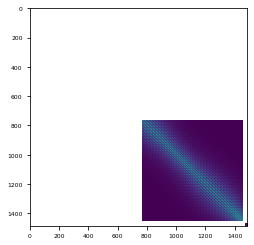

In [37]:
pst = pf.build_pst()
cov = pf.build_prior(fmt="none") # skip saving to a file...
x = cov.x.copy()
x[x==0] = np.NaN
plt.imshow(x)

See the little offset in the lower right?  there are a few parameters there in a small block:

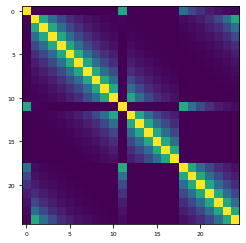

In [38]:
plt.imshow(x[-25:,-25:])

Those are our constant-in-space but correlated in time wel rate parameters - snap!

To compliment those stress period level constant multipliers, lets add a set of multipliers, one for each pumping well, that is broadcast across all stress periods (and let's add spatial correlation for these):

In [39]:
pf.add_parameters(filenames=wel_files,par_type="grid",par_name_base="wel_gr",
                     pargp="wel_gr", upper_bound = 1.5, lower_bound=0.5,
                  geostruct=grid_gs)

2021-11-20 20:05:36.677244 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_1.txt', 'freyberg6.wel_stress_period_data_10.txt', 'freyberg6.wel_stress_period_data_11.txt', 'freyberg6.wel_stress_period_data_12.txt', 'freyberg6.wel_stress_period_data_13.txt', 'freyberg6.wel_stress_period_data_14.txt', 'freyberg6.wel_stress_period_data_15.txt', 'freyberg6.wel_stress_period_data_16.txt', 'freyberg6.wel_stress_period_data_17.txt', 'freyberg6.wel_stress_period_data_18.txt', 'freyberg6.wel_stress_period_data_19.txt', 'freyberg6.wel_stress_period_data_2.txt', 'freyberg6.wel_stress_period_data_20.txt', 'freyberg6.wel_stress_period_data_21.txt', 'freyberg6.wel_stress_period_data_22.txt', 'freyberg6.wel_stress_period_data_23.txt', 'freyberg6.wel_stress_period_data_24.txt', 'freyberg6.wel_stress_period_data_25.txt', 'freyberg6.wel_stress_period_data_3.txt', 'freyberg6.wel_stress_period_data_4.txt', 'freyberg6.wel_stress_period_data_5.txt', 'freyberg6.wel_s

D:\modelling\pyemu\pyemu\logger.py:100: PyemuWarning: 2021-11-20 20:05:36.678244 WARNING: Discrepancy between number of filenames (25) and number of formatter strings (1). Will repeat first (free)



,parnme,parval1,i,j,x,y,pargp,tpl_filename,input_filename,partype,partrans,parubnd,parlbnd,parchglim,offset,scale,dercom
pname:wel_gr_inst:0_ptype:gr_pstyle:m_i:0_j:0_x:125.00_y:9875.00,pname:wel_gr_inst:0_ptype:gr_pstyle:m_i:0_j:0_x:125.00_y:9875.00,1.0,0,0,125.0,9875.0,wel_gr,freyberg6_template\wel_gr_inst0_grid.csv.tpl,freyberg6_template\mult\wel_gr_inst0_grid.csv,grid,log,1.5,0.5,factor,0.0,1.0,1
pname:wel_gr_inst:0_ptype:gr_pstyle:m_i:0_j:1_x:375.00_y:9875.00,pname:wel_gr_inst:0_ptype:gr_pstyle:m_i:0_j:1_x:375.00_y:9875.00,1.0,0,1,375.0,9875.0,wel_gr,freyberg6_template\wel_gr_inst0_grid.csv.tpl,freyberg6_template\mult\wel_gr_inst0_grid.csv,grid,log,1.5,0.5,factor,0.0,1.0,1
pname:wel_gr_inst:0_ptype:gr_pstyle:m_i:0_j:2_x:625.00_y:9875.00,pname:wel_gr_inst:0_ptype:gr_pstyle:m_i:0_j:2_x:625.00_y:9875.00,1.0,0,2,625.0,9875.0,wel_gr,freyberg6_template\wel_gr_inst0_grid.csv.tpl,freyberg6_template\mult\wel_gr_inst0_grid.csv,grid,log,1.5,0.5,factor,0.0,1.0,1
pname:wel_gr_inst:0_ptype:gr_pstyle:m_i:0_j:3_x:875.00_y:9875.00,pname:wel_gr_inst:0_ptype:gr_pstyle:m_i:0_j:3_x:875.00_y:9875.00,1.0,0,3,875.0,9875.0,wel_gr,freyberg6_template\wel_gr_inst0_grid.csv.tpl,freyberg6_template\mult\wel_gr_inst0_grid.csv,grid,log,1.5,0.5,factor,0.0,1.0,1
pname:wel_gr_inst:0_ptype:gr_pstyle:m_i:1_j:0_x:125.00_y:9625.00,pname:wel_gr_inst:0_ptype:gr_pstyle:m_i:1_j:0_x:125.00_y:9625.00,1.0,1,0,125.0,9625.0,wel_gr,freyberg6_template\wel_gr_inst0_grid.csv.tpl,freyberg6_template\mult\wel_gr_inst0_grid.csv,grid,log,1.5,0.5,factor,0.0,1.0,1
pname:wel_gr_inst:0_ptype:gr_pstyle:m_i:1_j:1_x:375.00_y:9625.00,pname:wel_gr_inst:0_ptype:gr_pstyle:m_i:1_j:1_x:375.00_y:9625.00,1.0,1,1,375.0,9625.0,wel_gr,freyberg6_template\wel_gr_inst0_grid.csv.tpl,freyberg6_template\mult\wel_gr_inst0_grid.csv,grid,log,1.5,0.5,factor,0.0,1.0,1
pname:wel_gr_inst:0_ptype:gr_pstyle:m_i:1_j:2_x:625.00_y:9625.00,pname:wel_gr_inst:0_ptype:gr_pstyle:m_i:1_j:2_x:625.00_y:9625.00,1.0,1,2,625.0,9625.0,wel_gr,freyberg6_template\wel_gr_inst0_grid.csv.tpl,freyberg6_template\mult\wel_gr_inst0_grid.csv,grid,log,1.5,0.5,factor,0.0,1.0,1
pname:wel_gr_inst:0_ptype:gr_pstyle:m_i:1_j:3_x:875.00_y:9625.00,pname:wel_gr_inst:0_ptype:gr_pstyle:m_i:1_j:3_x:875.00_y:9625.00,1.0,1,3,875.0,9625.0,wel_gr,freyberg6_template\wel_gr_inst0_grid.csv.tpl,freyberg6_template\mult\wel_gr_inst0_grid.csv,grid,log,1.5,0.5,factor,0.0,1.0,1
pname:wel_gr_inst:0_ptype:gr_pstyle:m_i:2_j:0_x:125.00_y:9375.00,pname:wel_gr_inst:0_ptype:gr_pstyle:m_i:2_j:0_x:125.00_y:9375.00,1.0,2,0,125.0,9375.0,wel_gr,freyberg6_template\wel_gr_inst0_grid.csv.tpl,freyberg6_template\mult\wel_gr_inst0_grid.csv,grid,log,1.5,0.5,factor,0.0,1.0,1
pname:wel_gr_inst:0_ptype:gr_pstyle:m_i:2_j:1_x:375.00_y:9375.00,pname:wel_gr_inst:0_ptype:gr_pstyle:m_i:2_j:1_x:375.00_y:9375.00,1.0,2,1,375.0,9375.0,wel_gr,freyberg6_template\wel_gr_inst0_grid.csv.tpl,freyberg6_template\mult\wel_gr_inst0_grid.csv,grid,log,1.5,0.5,factor,0.0,1.0,1


noptmax:0, npar_adj:1510, nnz_obs:825
2021-11-20 20:05:37.122852 WARNING: sys_cmd 'pyemu.os_utils.run(r'mf6')
' already in sys cmds, skipping...


D:\modelling\pyemu\pyemu\logger.py:100: PyemuWarning: 2021-11-20 20:05:37.122852 WARNING: sys_cmd 'pyemu.os_utils.run(r'mf6')
' already in sys cmds, skipping...



2021-11-20 20:05:37.173725 starting: building prior covariance matrix
2021-11-20 20:05:37.501067 finished: building prior covariance matrix took: 0:00:00.327342


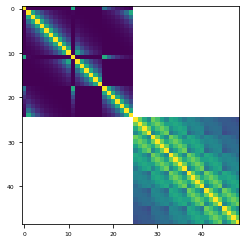

In [40]:
pst = pf.build_pst()
cov = pf.build_prior(fmt="none")
x = cov.x.copy()
x[x==0] = np.NaN
plt.imshow(x[-49:,-49:])

The upper left block is the constant-in-space but correlated-in-time wel rate multiplier parameters, while the lower right block is the constant-in-time but correlated-in-space wel rate multiplier parameters.  Boom!

## After building the control file

At this point, we can do some additional modifications that would typically be done that are problem specific.  Note that any modifications made after calling `PstFrom.build_pst()` will only exist in memory - you need to call `pf.pst.write()` to record these changes to the control file on disk.  Also note that if you call `PstFrom.build_pst()` after making some changes, these changes will be lost.  

### Additional parameters in existing template files

In many cases, you will have additional odd-ball parameters that arent in list or array file format that you want to include in the pest control.  To demonstrate how this works, lets make up a template file:

In [41]:
tpl_filename = os.path.join(template_ws,"special_pars.dat.tpl")
with open(tpl_filename,'w') as f:
    f.write("ptf ~\n")
    f.write("special_par1  ~  special_par1   ~\n")
    f.write("special_par2  ~  special_par2   ~\n")

In [42]:
pf.pst.add_parameters(tpl_filename,pst_path=".")

2 pars added from template file .\special_pars.dat.tpl


,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
special_par1,special_par1,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
special_par2,special_par2,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1


### Tying parameters

Let's say you want to tie some parameters in the control file.  This happens through the `Pst.parameter_data` dataframe.  Here let's tie the first parameter in the control file to the second:

In [43]:
par = pf.pst.parameter_data
par.loc[pf.pst.par_names[0],"partrans"] = "tied"
par.loc[pf.pst.par_names[0],"partied"] = pf.pst.par_names[1]

### Manipulating parameter bounds

While you can pass parameter bound information to `PstFrom.add_parameters()`, in many cases, you may want to change the bounds for individual parameters before build the prior parameter covariance matrix and/or generating the prior parameter ensemble.  This can be done through the `PstFrom.pst.parameter_data` dataframe:

In [44]:
par.loc[pf.pst.par_names[5:10],"parlbnd"]

pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:5_x:1375.00_y:9875.00_zone:1    0.1
pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:6_x:1625.00_y:9875.00_zone:1    0.1
pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:7_x:1875.00_y:9875.00_zone:1    0.1
pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:8_x:2125.00_y:9875.00_zone:1    0.1
pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:9_x:2375.00_y:9875.00_zone:1    0.1
Name: parlbnd, dtype: float64

In [45]:
par.loc[pf.pst.par_names[5:10],"parlbnd"] = 0.25
par.loc[pf.pst.par_names[5:10],"parlbnd"]

pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:5_x:1375.00_y:9875.00_zone:1    0.25
pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:6_x:1625.00_y:9875.00_zone:1    0.25
pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:7_x:1875.00_y:9875.00_zone:1    0.25
pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:8_x:2125.00_y:9875.00_zone:1    0.25
pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:9_x:2375.00_y:9875.00_zone:1    0.25
Name: parlbnd, dtype: float64

### Setting observation values and weights

So far, we have automated the setup for pest(++).  But one critical task remains and there is not an easy way to automate it:  setting the actual observed values and weights in the `* observation data` information.  `PstFrom` and `Pst` will both try to read existing model output files that correspond to instruction files and put those simulated values into the `* observation data` section for the observed values (the `obsval` quantity).  However, if you have actual observation data and you want to use pest(++) to try to match these data, then you need to get these values into the `* observation data` section and you will probably also need to adjust the `weight` quantities as well.  You can do this operation with `pandas` or you can save the control file in "version 2" format, which will write the `* observation data` section (along with the sections) as a CSV file, which can be imported into any number of spreadsheet programs.  

# Generating a prior parameter ensemble

This is crazy easy - using the previous defined correlation structures, we can draw from the block diagonal covariance matrix (and use spectral simulation for the grid-scale parameters):

In [46]:
pe = pf.draw(num_reals=100,use_specsim=True)

2021-11-20 20:05:37.754660 starting: drawing realizations
2021-11-20 20:05:37.774890 starting: spectral simulation for grid-scale pars
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2021-11-20 20:05:37.800834 starting: SpecSim: drawing 100 realization for group hk_layer_3 with 706 pars, (log) variance 0.1111111111111111 (sill 0.1111111111111111)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2021-11-20 20:05:37.852376 finished: SpecSim: drawing 100 realization for group hk_layer_3 with 706 pars, (log) variance 0.1111111111111111 (sill 0.1111111111111111) took: 0:00:00.051542
2021-11-20 20:05:37.854371 starting: SpecSim: drawing 100 realization for group wel_gr with 24 pars, (log) variance 0.006323463658479584 (sill 0.006323463658479584)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2021-11-20 20:05:37.896001 finished: SpecSim: drawing 100 realization for group wel_gr with 24 pars, (log) variance 0.006323463658479584 (sill 0.006323463658479584)

In [47]:
pe.to_csv(os.path.join(template_ws,"prior.csv"))

0     0.587537
1     1.158146
2     0.586938
3     0.997616
4     4.278282
        ...   
95    0.525511
96    0.480981
97    1.930194
98    1.579327
99    0.548943
Name: pname:hk_layer_1_inst:0_ptype:gr_pstyle:m_i:0_j:1_x:375.00_y:9875.00_zone:1, Length: 100, dtype: float64


<AxesSubplot:>

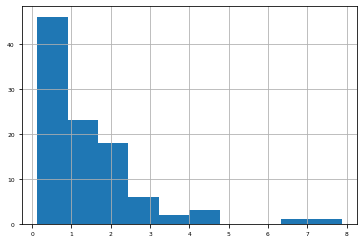

In [48]:
print(pe.loc[:,pst.adj_par_names[0]])
pe.loc[:,pst.adj_par_names[0]]._df.hist()

# Industrial strength control file setup

This functionality mimics the demonstration the `PstFrom` manuscript

In [49]:
# load the mf6 model with flopy to get the spatial reference
sim = flopy.mf6.MFSimulation.load(sim_ws=tmp_model_ws)
m = sim.get_model("freyberg6")

# work out the spatial rediscretization factor
redis_fac = m.dis.nrow.data / 40

# where the pest interface will be constructed
template_ws = tmp_model_ws.split('_')[1] + "_template"


# instantiate PstFrom object
pf = pyemu.utils.PstFrom(original_d=tmp_model_ws, new_d=template_ws,
             remove_existing=True,
             longnames=True, spatial_reference=m.modelgrid,
             zero_based=False,start_datetime="1-1-2018")

# add observations from the sfr observation output file
df = pd.read_csv(os.path.join(tmp_model_ws, "sfr.csv"), index_col=0)
pf.add_observations("sfr.csv", insfile="sfr.csv.ins", index_cols="time", 
                    use_cols=list(df.columns.values),
                    prefix="sfr")

# add observations for the heads observation output file
df = pd.read_csv(os.path.join(tmp_model_ws, "heads.csv"), index_col=0)
pf.add_observations("heads.csv", insfile="heads.csv.ins", 
                    index_cols="time", use_cols=list(df.columns.values),
                    prefix="hds")

# the geostruct object for grid-scale parameters
grid_v = pyemu.geostats.ExpVario(contribution=1.0,a=500)
grid_gs = pyemu.geostats.GeoStruct(variograms=grid_v)

# the geostruct object for pilot-point-scale parameters
pp_v = pyemu.geostats.ExpVario(contribution=1.0, a=2000)
pp_gs = pyemu.geostats.GeoStruct(variograms=pp_v)

# the geostruct for recharge grid-scale parameters
rch_v = pyemu.geostats.ExpVario(contribution=1.0, a=1000)
rch_gs = pyemu.geostats.GeoStruct(variograms=rch_v)

# the geostruct for temporal correlation
temporal_v = pyemu.geostats.ExpVario(contribution=1.0,a=60)
temporal_gs = pyemu.geostats.GeoStruct(variograms=temporal_v)

# import flopy as part of the forward run process
pf.extra_py_imports.append('flopy')

# use the idomain array for masking parameter locations
ib = m.dis.idomain[0].array

# define a dict that contains file name tags and lower/upper bound information
tags = {"npf_k_":[0.1,10.],"npf_k33_":[.1,10],"sto_ss":[.1,10],
		"sto_sy":[.9,1.1],"rch_recharge":[.5,1.5]}
dts = pd.to_datetime("1-1-2018") + \
      pd.to_timedelta(np.cumsum(sim.tdis.perioddata.array["perlen"]),unit="d")

# loop over each tag, bound info pair
for tag,bnd in tags.items():
    lb,ub = bnd[0],bnd[1]
    # find all array based files that have the tag in the name
    arr_files = [f for f in os.listdir(template_ws) if tag in f 
				 and f.endswith(".txt")]

    if len(arr_files) == 0:
        print("warning: no array files found for ",tag)
        continue
    
    # make sure each array file in nrow X ncol dimensions (not wrapped, sigh)
    for arr_file in arr_files:
        arr = np.loadtxt(os.path.join(template_ws,arr_file)).reshape(ib.shape)
        np.savetxt(os.path.join(template_ws,arr_file),arr,fmt="%15.6E")
    
    # if this is the recharge tag
    if "rch" in tag:
        # add one set of grid-scale parameters for all files
        pf.add_parameters(filenames=arr_files, par_type="grid", 
        				  par_name_base="rch_gr",pargp="rch_gr", 
        				  zone_array=ib, upper_bound=ub, 
        				  lower_bound=lb,geostruct=rch_gs)

        # add one constant parameter for each array, and 
        # assign it a datetime so we can work out the 
        # temporal correlation
        for arr_file in arr_files:
            kper = int(arr_file.split('.')[1].split('_')[-1]) - 1
            pf.add_parameters(filenames=arr_file,par_type="constant",
            			      par_name_base=arr_file.split('.')[1]+"_cn",
                              pargp="rch_const",zone_array=ib,upper_bound=ub,
                              lower_bound=lb,geostruct=temporal_gs,
                              datetime=dts[kper])
    # otherwise...
    else:
        # for each array add both grid-scale and pilot-point scale parameters
        for arr_file in arr_files:
            pf.add_parameters(filenames=arr_file,par_type="grid",
                              par_name_base=arr_file.split('.')[1]+"_gr",
                              pargp=arr_file.split('.')[1]+"_gr",zone_array=ib,
                              upper_bound=ub,lower_bound=lb,
                              geostruct=grid_gs)
            pf.add_parameters(filenames=arr_file, par_type="pilotpoints", 
                              par_name_base=arr_file.split('.')[1]+"_pp",
                              pargp=arr_file.split('.')[1]+"_pp", 
                              zone_array=ib,upper_bound=ub,lower_bound=lb,
                              pp_space=int(5 * redis_fac),geostruct=pp_gs)


# get all the list-type files associated with the wel package
list_files = [f for f in os.listdir(tmp_model_ws) if 
			  "freyberg6.wel_stress_period_data_" 
              in f and f.endswith(".txt")]
# for each wel-package list-type file 
for list_file in list_files:
    kper = int(list_file.split(".")[1].split('_')[-1]) - 1
    # add spatially constant, but temporally correlated parameter
    pf.add_parameters(filenames=list_file,par_type="constant",
    				  par_name_base="twel_mlt_{0}".format(kper),
                      pargp="twel_mlt".format(kper),index_cols=[0,1,2],
                      use_cols=[3],upper_bound=1.5,lower_bound=0.5, 
                      datetime=dts[kper], geostruct=temporal_gs)

    # add temporally indep, but spatially correlated grid-scale 
    # parameters, one per well
    pf.add_parameters(filenames=list_file, par_type="grid", 
                      par_name_base="wel_grid_{0}".format(kper),
                      pargp="wel_{0}".format(kper), index_cols=[0, 1, 2], 
                      use_cols=[3],upper_bound=1.5, lower_bound=0.5)

# add grid-scale parameters for SFR reach conductance.  
# Use layer, row, col and reach number in the 
# parameter names
pf.add_parameters(filenames="freyberg6.sfr_packagedata.txt", 
                  par_name_base="sfr_rhk",
                  pargp="sfr_rhk", index_cols=[0,1,2,3], 
                  use_cols=[9], upper_bound=10.,
                  lower_bound=0.1,
                  par_type="grid")

# add model run command
pf.mod_sys_cmds.append("mf6")

# build pest control file
pst = pf.build_pst('freyberg.pst')

# draw from the prior and save the ensemble in binary format
pe = pf.draw(100, use_specsim=True)
pe.to_binary(os.path.join(template_ws, "prior.jcb"))

# set some algorithmic controls
pst.control_data.noptmax = 0
pst.pestpp_options["additional_ins_delimiters"] = ","

# write the control file
pst.write(os.path.join(pf.new_d, "freyberg.pst"))

# run with noptmax = 0
pyemu.os_utils.run("{0} freyberg.pst".format(
    os.path.join("pestpp-ies")), cwd=pf.new_d)

# make sure it ran
res_file = os.path.join(pf.new_d, "freyberg.base.rei")
assert os.path.exists(res_file), res_file
pst.set_res(res_file)
print(pst.phi)

# if successful, set noptmax = -1 for prior-based Monte Carlo
pst.control_data.noptmax = -1

# define what file has the prior parameter ensemble
pst.pestpp_options["ies_par_en"] = "prior.jcb"

# write the updated pest control file
pst.write(os.path.join(pf.new_d, "freyberg.pst"))

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package oc...
    loading package wel...
    loading package rch...
    loading package ghb...
    loading package sfr...
    loading package obs...
  loading ims package freyberg6...
2021-11-20 20:05:39.106930 starting: opening PstFrom.log for logging
2021-11-20 20:05:39.106930 starting PstFrom process
2021-11-20 20:05:39.106930 starting: setting up dirs
2021-11-20 20:05:39.106930 starting: removing existing new_d 'pst_template'
2021-11-20 20:05:39.233911 finished: removing existing new_d 'pst_template' took: 0:00:00.126981
2021-11-20 20:05:39.233911 starting: copying original_d 'temp_pst_from' to new_d 'pst_template'
2021-11-20 20:05:39.313754 finished: copying original_d 'temp_pst_from' to new_d 'pst_template' took: 0:00:00.079843
2021-11-20 20:05:39.313754 fini

D:\modelling\pyemu\pyemu\logger.py:100: PyemuWarning: 2021-11-20 20:05:39.531202 WARNING: 0) Inconsistency between geostruct transform and partrans.

D:\modelling\pyemu\pyemu\logger.py:100: PyemuWarning: 2021-11-20 20:05:39.531202 WARNING: 1) Setting geostruct transform to {transform}

D:\modelling\pyemu\pyemu\logger.py:100: PyemuWarning: 2021-11-20 20:05:39.532190 WARNING: -) Better to pass an appropriately transformed geostruct

D:\modelling\pyemu\pyemu\logger.py:100: PyemuWarning: 2021-11-20 20:05:39.585157 WARNING: 0) Inconsistency between geostruct transform and partrans.

D:\modelling\pyemu\pyemu\logger.py:100: PyemuWarning: 2021-11-20 20:05:39.585157 WARNING: 1) Setting geostruct transform to {transform}

D:\modelling\pyemu\pyemu\logger.py:100: PyemuWarning: 2021-11-20 20:05:39.585157 WARNING: -) Better to pass an appropriately transformed geostruct



starting 0
starting 1
starting 2
starting 3
starting 4
starting 5
starting 6
starting 7
starting 8
starting 9
took 3.849172 seconds
2021-11-20 20:05:43.560221 finished: calculating factors for pargp=npf_k_layer1_pp took: 0:00:03.887819
2021-11-20 20:05:43.560221 starting: writing array-based template file 'pst_template\npf_k_layer1_pp_inst0pp.dat.tpl'
2021-11-20 20:05:43.560221 saving zone array pst_template\npf_k_layer1_pp_inst0pp.dat.zone for tpl file pst_template\npf_k_layer1_pp_inst0pp.dat.tpl
2021-11-20 20:05:43.575898 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt'] took: 0:00:03.990741
2021-11-20 20:05:43.575898 starting: adding grid type m style parameters for file(s) ['freyberg6.npf_k_layer2.txt']
2021-11-20 20:05:43.575898 starting: loading array pst_template\freyberg6.npf_k_layer2.txt
2021-11-20 20:05:43.600057 finished: loading array pst_template\freyberg6.npf_k_layer2.txt took: 0:00:00.024159
2021-11-20 20:05:43.600057 loaded 

2021-11-20 20:05:44.122742 finished: writing template file pst_template\npf_k33_layer2_gr_inst0_grid.csv.tpl for ['npf_k33_layer2_gr_inst:0'] took: 0:00:00.015630
2021-11-20 20:05:44.122742 starting: writing array-based template file 'pst_template\npf_k33_layer2_gr_inst0_grid.csv.tpl'
2021-11-20 20:05:44.122742 saving zone array pst_template\npf_k33_layer2_gr_inst0_grid.csv.zone for tpl file pst_template\npf_k33_layer2_gr_inst0_grid.csv.tpl
2021-11-20 20:05:44.155812 finished: adding grid type m style parameters for file(s) ['freyberg6.npf_k33_layer2.txt'] took: 0:00:00.064721
2021-11-20 20:05:44.156807 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k33_layer2.txt']
2021-11-20 20:05:44.156807 starting: loading array pst_template\freyberg6.npf_k33_layer2.txt
2021-11-20 20:05:44.158799 finished: loading array pst_template\freyberg6.npf_k33_layer2.txt took: 0:00:00.001992
2021-11-20 20:05:44.158799 loaded array 'temp_pst_from\freyberg6.npf_k33_layer2.txt'

2021-11-20 20:05:44.933038 saving zone array pst_template\sto_ss_layer2_pp_inst0pp.dat.zone for tpl file pst_template\sto_ss_layer2_pp_inst0pp.dat.tpl
2021-11-20 20:05:44.940011 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.sto_ss_layer2.txt'] took: 0:00:00.145656
2021-11-20 20:05:44.941005 starting: adding grid type m style parameters for file(s) ['freyberg6.sto_ss_layer3.txt']
2021-11-20 20:05:44.941005 starting: loading array pst_template\freyberg6.sto_ss_layer3.txt
2021-11-20 20:05:44.955942 finished: loading array pst_template\freyberg6.sto_ss_layer3.txt took: 0:00:00.014937
2021-11-20 20:05:44.955942 loaded array 'temp_pst_from\freyberg6.sto_ss_layer3.txt' of shape (40, 20)
2021-11-20 20:05:44.958224 starting: writing array-style template file 'pst_template\sto_ss_layer3_gr_inst0_grid.csv.tpl'
2021-11-20 20:05:44.959216 starting: writing template file pst_template\sto_ss_layer3_gr_inst0_grid.csv.tpl for ['sto_ss_layer3_gr_inst:0']
2021-11-20 20:05:4

2021-11-20 20:05:45.523041 finished: adding grid type m style parameters for file(s) ['freyberg6.sto_sy_layer3.txt'] took: 0:00:00.044574
2021-11-20 20:05:45.523041 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.sto_sy_layer3.txt']
2021-11-20 20:05:45.524037 starting: loading array pst_template\freyberg6.sto_sy_layer3.txt
2021-11-20 20:05:45.526029 finished: loading array pst_template\freyberg6.sto_sy_layer3.txt took: 0:00:00.001992
2021-11-20 20:05:45.526029 loaded array 'temp_pst_from\freyberg6.sto_sy_layer3.txt' of shape (40, 20)
2021-11-20 20:05:45.528020 starting: writing array-style template file 'pst_template\sto_sy_layer3_pp_inst0_pilotpoints.csv.tpl'
2021-11-20 20:05:45.528020 starting: setting up pilot point parameters
2021-11-20 20:05:45.528020 No spatial reference (containing cell spacing) passed.
2021-11-20 20:05:45.528020 OK - using spatial reference in parent object.
2021-11-20 20:05:45.608296 29 pilot point parameters created
2021-11-20 20:

D:\modelling\pyemu\pyemu\logger.py:100: PyemuWarning: 2021-11-20 20:05:45.947876 WARNING: 0) Inconsistency between geostruct transform and partrans.

D:\modelling\pyemu\pyemu\logger.py:100: PyemuWarning: 2021-11-20 20:05:45.948881 WARNING: 1) Setting geostruct transform to {transform}

D:\modelling\pyemu\pyemu\logger.py:100: PyemuWarning: 2021-11-20 20:05:45.948881 WARNING: -) Better to pass an appropriately transformed geostruct

D:\modelling\pyemu\pyemu\logger.py:100: PyemuWarning: 2021-11-20 20:05:45.948881 WARNING: Discrepancy between number of filenames (25) and number of formatter strings (1). Will repeat first (free)



2021-11-20 20:05:46.144836 loaded array 'temp_pst_from\freyberg6.rch_recharge_19.txt' of shape (40, 20)
2021-11-20 20:05:46.150809 starting: loading array pst_template\freyberg6.rch_recharge_2.txt
2021-11-20 20:05:46.163171 finished: loading array pst_template\freyberg6.rch_recharge_2.txt took: 0:00:00.012362
2021-11-20 20:05:46.163171 loaded array 'temp_pst_from\freyberg6.rch_recharge_2.txt' of shape (40, 20)
2021-11-20 20:05:46.167154 starting: loading array pst_template\freyberg6.rch_recharge_20.txt
2021-11-20 20:05:46.177112 finished: loading array pst_template\freyberg6.rch_recharge_20.txt took: 0:00:00.009958
2021-11-20 20:05:46.177112 loaded array 'temp_pst_from\freyberg6.rch_recharge_20.txt' of shape (40, 20)
2021-11-20 20:05:46.180099 starting: loading array pst_template\freyberg6.rch_recharge_21.txt
2021-11-20 20:05:46.194041 finished: loading array pst_template\freyberg6.rch_recharge_21.txt took: 0:00:00.013942
2021-11-20 20:05:46.195040 loaded array 'temp_pst_from\freyberg6

D:\modelling\pyemu\pyemu\logger.py:100: PyemuWarning: 2021-11-20 20:05:46.450630 WARNING: 0) Inconsistency between geostruct transform and partrans.

D:\modelling\pyemu\pyemu\logger.py:100: PyemuWarning: 2021-11-20 20:05:46.450630 WARNING: 1) Setting geostruct transform to {transform}

D:\modelling\pyemu\pyemu\logger.py:100: PyemuWarning: 2021-11-20 20:05:46.450630 WARNING: -) Better to pass an appropriately transformed geostruct



2021-11-20 20:05:46.523738 starting: loading array pst_template\freyberg6.rch_recharge_12.txt
2021-11-20 20:05:46.523738 finished: loading array pst_template\freyberg6.rch_recharge_12.txt took: 0:00:00
2021-11-20 20:05:46.523738 loaded array 'temp_pst_from\freyberg6.rch_recharge_12.txt' of shape (40, 20)
2021-11-20 20:05:46.523738 starting: writing array-style template file 'pst_template\rch_recharge_12_cn_inst0_constant.csv.tpl'
2021-11-20 20:05:46.523738 starting: writing template file pst_template\rch_recharge_12_cn_inst0_constant.csv.tpl for ['rch_recharge_12_cn_inst:0']
2021-11-20 20:05:46.540844 finished: writing template file pst_template\rch_recharge_12_cn_inst0_constant.csv.tpl for ['rch_recharge_12_cn_inst:0'] took: 0:00:00.017106
2021-11-20 20:05:46.540844 starting: writing array-based template file 'pst_template\rch_recharge_12_cn_inst0_constant.csv.tpl'
2021-11-20 20:05:46.541837 saving zone array pst_template\rch_recharge_12_cn_inst0_constant.csv.zone for tpl file pst_tem

2021-11-20 20:05:46.706690 finished: writing template file pst_template\rch_recharge_19_cn_inst0_constant.csv.tpl for ['rch_recharge_19_cn_inst:0'] took: 0:00:00.008925
2021-11-20 20:05:46.707686 starting: writing array-based template file 'pst_template\rch_recharge_19_cn_inst0_constant.csv.tpl'
2021-11-20 20:05:46.707686 saving zone array pst_template\rch_recharge_19_cn_inst0_constant.csv.zone for tpl file pst_template\rch_recharge_19_cn_inst0_constant.csv.tpl
2021-11-20 20:05:46.716690 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_19.txt'] took: 0:00:00.023898
2021-11-20 20:05:46.716690 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_2.txt']
2021-11-20 20:05:46.716690 starting: loading array pst_template\freyberg6.rch_recharge_2.txt
2021-11-20 20:05:46.718676 finished: loading array pst_template\freyberg6.rch_recharge_2.txt took: 0:00:00.001986
2021-11-20 20:05:46.718676 loaded array 'temp_pst_from\freybe

2021-11-20 20:05:46.898428 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_3.txt'] took: 0:00:00.025726
2021-11-20 20:05:46.898428 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_4.txt']
2021-11-20 20:05:46.898428 starting: loading array pst_template\freyberg6.rch_recharge_4.txt
2021-11-20 20:05:46.900414 finished: loading array pst_template\freyberg6.rch_recharge_4.txt took: 0:00:00.001986
2021-11-20 20:05:46.900414 loaded array 'temp_pst_from\freyberg6.rch_recharge_4.txt' of shape (40, 20)
2021-11-20 20:05:46.903406 starting: writing array-style template file 'pst_template\rch_recharge_4_cn_inst0_constant.csv.tpl'
2021-11-20 20:05:46.903406 starting: writing template file pst_template\rch_recharge_4_cn_inst0_constant.csv.tpl for ['rch_recharge_4_cn_inst:0']
2021-11-20 20:05:46.911328 finished: writing template file pst_template\rch_recharge_4_cn_inst0_constant.csv.tpl for ['rch_recharge_4_cn_inst:0'] took: 

2021-11-20 20:05:47.091494 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_1.txt'] took: 0:00:00.031233
2021-11-20 20:05:47.091494 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_10.txt']
2021-11-20 20:05:47.091494 starting: loading list-style pst_template\freyberg6.wel_stress_period_data_10.txt
2021-11-20 20:05:47.091494 starting: reading list-style file: pst_template\freyberg6.wel_stress_period_data_10.txt
2021-11-20 20:05:47.091494 finished: reading list-style file: pst_template\freyberg6.wel_stress_period_data_10.txt took: 0:00:00
2021-11-20 20:05:47.091494 loaded list-style 'pst_template\freyberg6.wel_stress_period_data_10.txt' of shape (6, 4)
2021-11-20 20:05:47.091494 finished: loading list-style pst_template\freyberg6.wel_stress_period_data_10.txt took: 0:00:00
2021-11-20 20:05:47.091494 starting: writing list-style template file 'pst_template\twel_mlt_9_inst0_constant.csv.tpl'
2021-11

2021-11-20 20:05:47.472181 finished: writing list-style template file 'pst_template\twel_mlt_15_inst0_constant.csv.tpl' took: 0:00:00.015671
2021-11-20 20:05:47.486233 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_16.txt'] took: 0:00:00.029723
2021-11-20 20:05:47.486233 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_16.txt']
2021-11-20 20:05:47.486233 starting: loading list-style pst_template\freyberg6.wel_stress_period_data_16.txt
2021-11-20 20:05:47.486233 starting: reading list-style file: pst_template\freyberg6.wel_stress_period_data_16.txt
2021-11-20 20:05:47.486233 finished: reading list-style file: pst_template\freyberg6.wel_stress_period_data_16.txt took: 0:00:00
2021-11-20 20:05:47.486233 loaded list-style 'pst_template\freyberg6.wel_stress_period_data_16.txt' of shape (6, 4)
2021-11-20 20:05:47.486233 finished: loading list-style pst_template\freyberg6.wel_stress_period_data_16.tx

2021-11-20 20:05:47.872655 finished: reading list-style file: pst_template\freyberg6.wel_stress_period_data_22.txt took: 0:00:00.015673
2021-11-20 20:05:47.872655 loaded list-style 'pst_template\freyberg6.wel_stress_period_data_22.txt' of shape (6, 4)
2021-11-20 20:05:47.872655 finished: loading list-style pst_template\freyberg6.wel_stress_period_data_22.txt took: 0:00:00.015673
2021-11-20 20:05:47.872655 starting: writing list-style template file 'pst_template\wel_grid_21_inst0_grid.csv.tpl'
2021-11-20 20:05:47.890849 finished: writing list-style template file 'pst_template\wel_grid_21_inst0_grid.csv.tpl' took: 0:00:00.018194
2021-11-20 20:05:47.896823 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_22.txt'] took: 0:00:00.039841
2021-11-20 20:05:47.896823 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_23.txt']
2021-11-20 20:05:47.896823 starting: loading list-style pst_template\freyberg6.wel

2021-11-20 20:05:48.249009 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_5.txt'] took: 0:00:00.025184
2021-11-20 20:05:48.249009 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_6.txt']
2021-11-20 20:05:48.249009 starting: loading list-style pst_template\freyberg6.wel_stress_period_data_6.txt
2021-11-20 20:05:48.249009 starting: reading list-style file: pst_template\freyberg6.wel_stress_period_data_6.txt
2021-11-20 20:05:48.249009 finished: reading list-style file: pst_template\freyberg6.wel_stress_period_data_6.txt took: 0:00:00
2021-11-20 20:05:48.249009 loaded list-style 'pst_template\freyberg6.wel_stress_period_data_6.txt' of shape (6, 4)
2021-11-20 20:05:48.261912 finished: loading list-style pst_template\freyberg6.wel_stress_period_data_6.txt took: 0:00:00.012903
2021-11-20 20:05:48.261912 starting: writing list-style template file 'pst_template\twel_mlt_5_inst0_constant.csv.tpl'
2021-1

noptmax:0, npar_adj:9766, nnz_obs:725
2021-11-20 20:05:49.769676 forward_run line:pyemu.os_utils.run(r'mf6')

2021-11-20 20:05:50.069832 starting: drawing realizations
2021-11-20 20:05:50.153312 starting: spectral simulation for grid-scale pars
SpecSim.initialize() summary: full_delx X full_dely: 56 X 56
2021-11-20 20:05:50.275465 starting: SpecSim: drawing 100 realization for group npf_k_layer1_gr with 706 pars, (log) variance 0.1111111111111111 (sill 0.1111111111111111)
SpecSim.initialize() summary: full_delx X full_dely: 56 X 56
2021-11-20 20:05:50.326800 finished: SpecSim: drawing 100 realization for group npf_k_layer1_gr with 706 pars, (log) variance 0.1111111111111111 (sill 0.1111111111111111) took: 0:00:00.051335
2021-11-20 20:05:50.333919 starting: SpecSim: drawing 100 realization for group npf_k_layer2_gr with 706 pars, (log) variance 0.1111111111111111 (sill 0.1111111111111111)
SpecSim.initialize() summary: full_delx X full_dely: 56 X 56
2021-11-20 20:05:50.390021 finished: S

2021-11-20 20:05:53.676096 finished: Drawing non-specsim pars took: 0:00:02.662803
2021-11-20 20:05:54.706651 finished: drawing realizations took: 0:00:04.636819
noptmax:0, npar_adj:9766, nnz_obs:725
52.728343263199065
noptmax:-1, npar_adj:9766, nnz_obs:725
